# New Haven Housing Prices

## Imports and Data Sources

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow as tf

from datetime import timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV 

In [2]:
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

In [3]:
fed_files = ['data/MORTGAGE30US.csv', 'data/RRVRUSQ156N.csv', 'data/CPIAUCSL.csv']
zillow_files = ['data/Metro_median_sale_price_uc_sfrcondo_week.csv', 'data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv']

## Clean Preprocess Data

### Fed Data
Import the mortgage, vacancy, and inflation rates data. 
* The interest rates are reported weekly.
* The inflation rate is reported monthly.
* The vacancy rate is reported quarterly.

Combine all datasets into a single dataframe. The dates will be used as an index so that the data will by synced. There were many rows with NaN values. The indexed dates will be forward filled, so that past values will be constant for that time frame. Drop rows that do not have any mortgage, interest, or rental data. Only want rows that have all three indicators. Fed releases data every Thursday but Zillow releases data two days after. Need to shift Fed data by two days so that dataframe will have full rows.

In [4]:
dfs_f = [pd.read_csv(f, parse_dates=True, index_col=0) for f in fed_files]

In [5]:
dfs_f[0], dfs_f[1], dfs_f[2]

(            MORTGAGE30US
 DATE                    
 1971-04-02          7.33
 1971-04-09          7.31
 1971-04-16          7.31
 1971-04-23          7.31
 1971-04-30          7.29
 ...                  ...
 2022-07-14          5.51
 2022-07-21          5.54
 2022-07-28          5.30
 2022-08-04          4.99
 2022-08-11          5.22
 
 [2681 rows x 1 columns],
             RRVRUSQ156N
 DATE                   
 1956-01-01          6.2
 1956-04-01          5.9
 1956-07-01          6.3
 1956-10-01          5.8
 1957-01-01          5.3
 ...                 ...
 2021-04-01          6.2
 2021-07-01          5.8
 2021-10-01          5.6
 2022-01-01          5.8
 2022-04-01          5.6
 
 [266 rows x 1 columns],
             CPIAUCSL
 DATE                
 1947-01-01    21.480
 1947-02-01    21.620
 1947-03-01    22.000
 1947-04-01    22.000
 1947-05-01    21.950
 ...              ...
 2022-03-01   287.708
 2022-04-01   288.663
 2022-05-01   291.474
 2022-06-01   295.328
 2022-07-01   295.

In [6]:
fed_data = pd.concat(dfs_f, axis=1)

In [7]:
fed_data

MORTGAGE30US  RRVRUSQ156N  CPIAUCSL
DATE                                           
1947-01-01           NaN          NaN     21.48
1947-02-01           NaN          NaN     21.62
1947-03-01           NaN          NaN     22.00
1947-04-01           NaN          NaN     22.00
1947-05-01           NaN          NaN     21.95
...                  ...          ...       ...
2022-07-14          5.51          NaN       NaN
2022-07-21          5.54          NaN       NaN
2022-07-28          5.30          NaN       NaN
2022-08-04          4.99          NaN       NaN
2022-08-11          5.22          NaN       NaN

[3507 rows x 3 columns]

In [8]:
fed_data = fed_data.ffill()

In [9]:
fed_data.columns = ['interest', 'vacancy', 'inflation']

In [10]:
fed_data.dropna(inplace=True)

In [11]:
fed_data.index = fed_data.index + timedelta(days=2)

In [12]:
fed_data

interest  vacancy  inflation
DATE                                    
1971-04-04      7.33      5.3     40.100
1971-04-11      7.31      5.3     40.100
1971-04-18      7.31      5.3     40.100
1971-04-25      7.31      5.3     40.100
1971-05-02      7.29      5.3     40.100
...              ...      ...        ...
2022-07-16      5.51      5.6    295.271
2022-07-23      5.54      5.6    295.271
2022-07-30      5.30      5.6    295.271
2022-08-06      4.99      5.6    295.271
2022-08-13      5.22      5.6    295.271

[3215 rows x 3 columns]

### Real Estate Data
The Zillow data has data from the entire country. The New Haven, CT region is the only row of interest. The index will have to be changed to a DateTime datatype so that can be easily worked with. The only features from these datasets are the values in the dates. Combining both datasets will need to have a common column. A month column will be created from the index so that they can be joined. The month column will be dropped because it won't be used.

In [13]:
dfs_z = [pd.read_csv(f) for f in zillow_files]

In [14]:
dfs_z[0].iloc[58], dfs_z[1].iloc[62]

(RegionID             394908
 SizeRank                 62
 RegionName    New Haven, CT
 RegionType              Msa
 StateName                CT
                   ...      
 2022-06-11         289000.0
 2022-06-18         323500.0
 2022-06-25         325000.0
 2022-07-02         336000.0
 2022-07-09         332500.0
 Name: 58, Length: 759, dtype: object,
 RegionID             394908
 SizeRank                 62
 RegionName    New Haven, CT
 RegionType              Msa
 StateName                CT
                   ...      
 2022-03-31    322784.601833
 2022-04-30    328197.594137
 2022-05-31    332060.842851
 2022-06-30    333306.133814
 2022-07-31    334611.952987
 Name: 62, Length: 324, dtype: object)

In [15]:
dfs_z[0] = pd.DataFrame(dfs_z[0].iloc[58, 5:])
dfs_z[1] = pd.DataFrame(dfs_z[1].iloc[62, 5:])

In [16]:
for df in dfs_z:
    df.index = pd.to_datetime(df.index)
    df['month'] = df.index.to_period('M')

In [17]:
price_data = dfs_z[0].merge(dfs_z[1], on='month')

In [18]:
price_data.index = dfs_z[0].index

In [19]:
price_data.drop(columns=['month'], inplace=True)

In [20]:
price_data.columns = ['price', 'value']

In [21]:
price_data = price_data.apply(lambda col: pd.to_numeric(col, errors='coerce') if col.dtypes == 'object' else col)

In [22]:
price_data

price          value
2008-02-02  215000.0  273942.264635
2008-02-09  226750.0  273942.264635
2008-02-16  247000.0  273942.264635
2008-02-23  237500.0  273942.264635
2008-03-01  220000.0  271370.548263
...              ...            ...
2022-06-11  289000.0  333306.133814
2022-06-18  323500.0  333306.133814
2022-06-25  325000.0  333306.133814
2022-07-02  336000.0  334611.952987
2022-07-09  332500.0  334611.952987

[754 rows x 2 columns]

### Combine Data Frames
Fed reports are released every Thursday. Zillow releases their housing data two days after. Need to shift the Fed data two days so that it will create rows with data for all the features.

In [23]:
fed_data, price_data

(            interest  vacancy  inflation
 DATE                                    
 1971-04-04      7.33      5.3     40.100
 1971-04-11      7.31      5.3     40.100
 1971-04-18      7.31      5.3     40.100
 1971-04-25      7.31      5.3     40.100
 1971-05-02      7.29      5.3     40.100
 ...              ...      ...        ...
 2022-07-16      5.51      5.6    295.271
 2022-07-23      5.54      5.6    295.271
 2022-07-30      5.30      5.6    295.271
 2022-08-06      4.99      5.6    295.271
 2022-08-13      5.22      5.6    295.271
 
 [3215 rows x 3 columns],
                price          value
 2008-02-02  215000.0  273942.264635
 2008-02-09  226750.0  273942.264635
 2008-02-16  247000.0  273942.264635
 2008-02-23  237500.0  273942.264635
 2008-03-01  220000.0  271370.548263
 ...              ...            ...
 2022-06-11  289000.0  333306.133814
 2022-06-18  323500.0  333306.133814
 2022-06-25  325000.0  333306.133814
 2022-07-02  336000.0  334611.952987
 2022-07-09  332500

In [24]:
df = fed_data.merge(price_data, left_index=True, right_index=True)

## Exploratory Analysis
See the price trends and the impact the inflation rate had. View the true house prices without inflation. Look for correlations or interesting patterns.
### The data frame features and descriptions.
---
| Column | Description |
| ------ | ----------- |
| interest | 30 year mortgage interest rate |
| vacancy | Empty properties relative to total properties |
| cpi | Consumer Price Index (Inflation) |
| price | Sold price of property |
| value | Zillow's estimated home value |
| adj_price | True price without inflation |
| adj_value | True value without inflation |
| next_quarter | Future value of house n rows from current |
| increase | Boolean for an increase in price based on horizon |
| interest_ratio | The current interest rate relative to the yearly mean |
| vacancy_ratio | The vacancy rate relative to the yearly mean |
| adj_price_ratio | The adjusted price relative to the yearly adjusted price |
| adj_value_ratio | The adjusted value relative to the yearly adjusted value |

In [25]:
color_pal = sns.color_palette()
plt.style.use('fast')

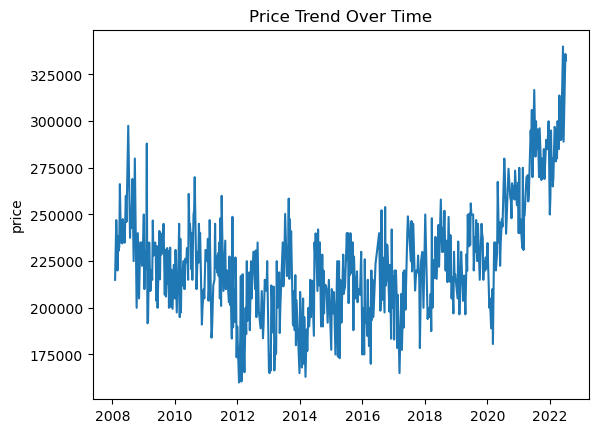

In [26]:
sns.lineplot(data=df, x=df.index, y='price')
plt.title('Price Trend Over Time')
plt.show()

There is a steady rise in home prices after 2020.

In [27]:
df['adj_price'] = df['price'] / df['inflation'] * 100

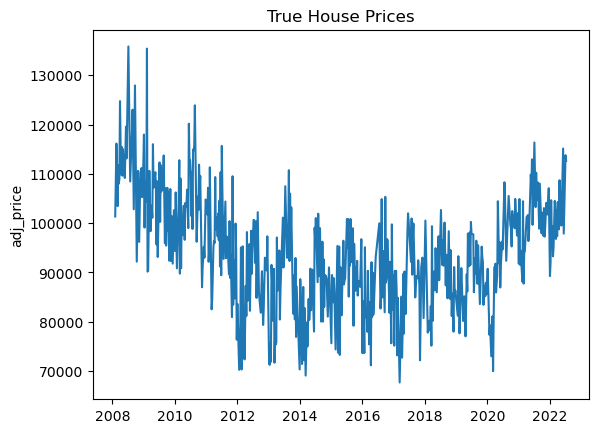

In [28]:
sns.lineplot(data=df, x=df.index, y='adj_price')
plt.title('True House Prices')
plt.show()

Inflation had a big impact on house prices. The prices never made it back to the Great Recession levels.

In [29]:
df['adj_value'] = df['value'] / df['inflation'] * 100

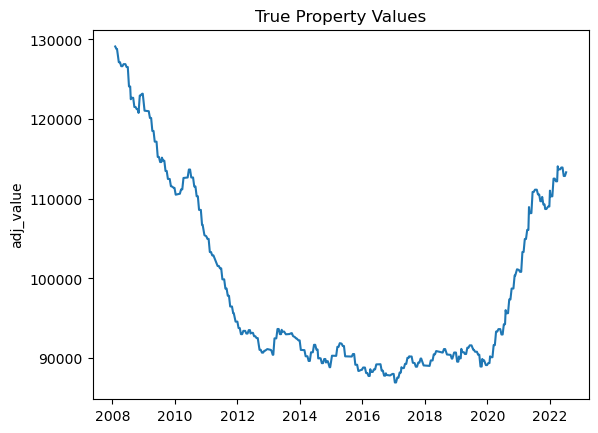

In [30]:
sns.lineplot(data=df, x=df.index, y='adj_value')
plt.title('True Property Values')
plt.show()

The values of the houses never really came back to pre-recession levels.

In [31]:
corr_df = df.corr(numeric_only=True)

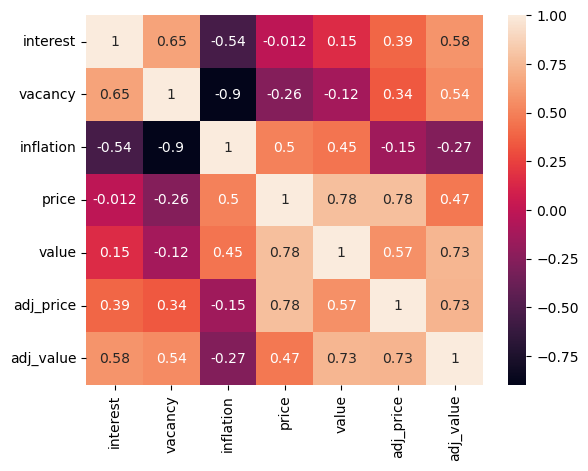

In [32]:
sns.heatmap(corr_df, annot=True)
plt.show()

There is a strong positive correlation with interest, vacancy, price, and value.
There is a strong negative correlation with vacancy and inflation.

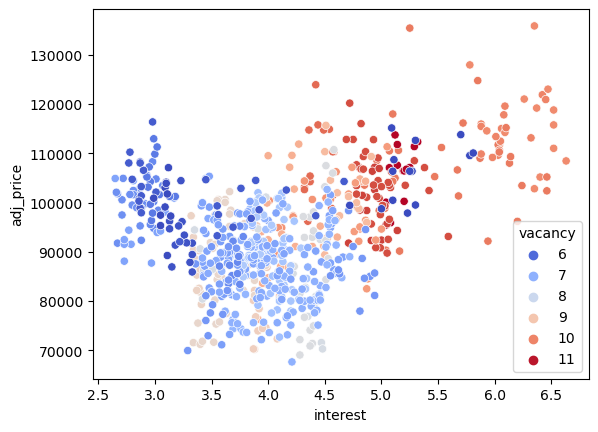

In [33]:
sns.scatterplot(x='interest', y='adj_price', data=df, hue='vacancy', palette='coolwarm')
plt.show()

There looks to be more vacancies when the interest rate got higher.

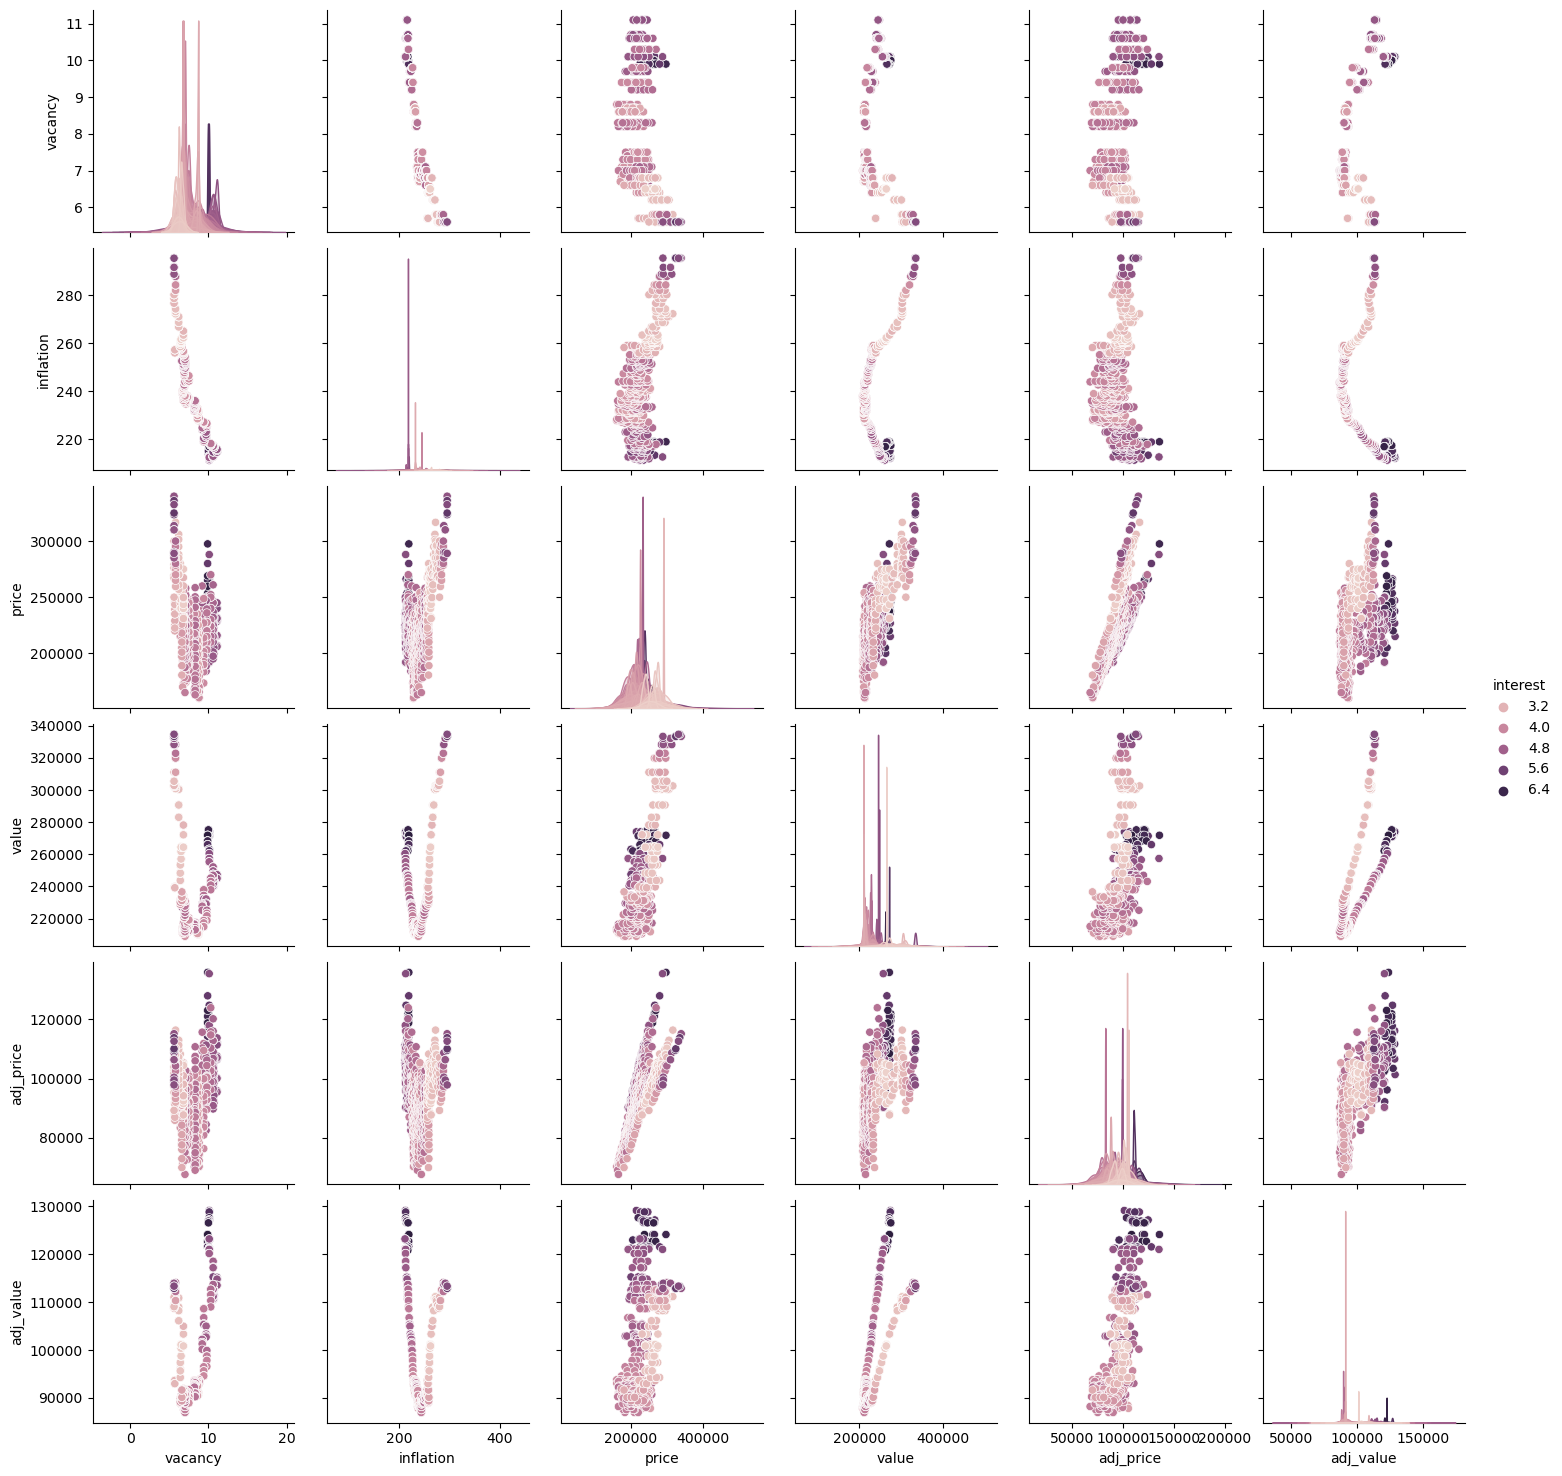

In [34]:
sns.pairplot(df, hue='interest')
plt.show()

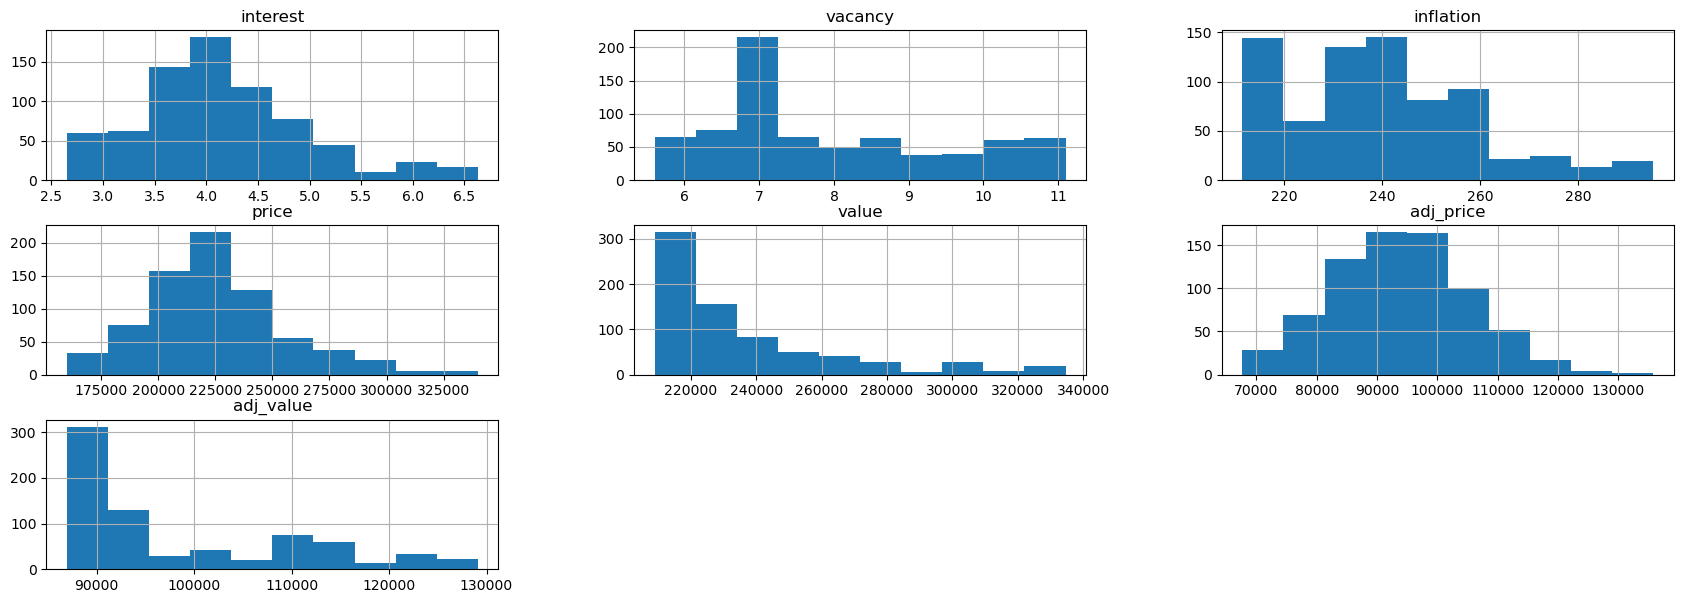

In [35]:
df.hist(figsize=(21, 7))
plt.show()

It looks like there are majority of home values are left skewed.

## Machine Learning Models
---
* Random Forest Classifier 
* Naive Bayes
* Support Vector Machines
* Neural Network

### Random Forest Classifier
Create a target column for the model to predict. Add a column for future sale prices so that a price increase can be determined. Use 3 months as the baseline horizon. Can't use rows that don't have a future price for training. Balance the target variable. Random Forest should be able to handle unbalanced data. Use the parameters that have the strongest correlations.

In [36]:
TIME = 13

df['next_quarter'] = df['adj_price'].shift(-TIME)

In [37]:
df.dropna(inplace=True)

Create the target variable.

In [38]:
df['increase'] = (df['next_quarter'] > df['adj_price']).astype(int)

In [39]:
df['increase'].value_counts()

0    364
1    358
Name: increase, dtype: int64

Create a baseline model and score. Use the parameters that had the strongest correlation.

In [40]:
parameters = ['interest', 'vacancy', 'price', 'value', 'inflation']
target = 'increase'

Training the model.

In [41]:
def predict(train, test, parameters, target):
    rf = RandomForestClassifier(min_samples_split=10, random_state=1)
    rf.fit(train[parameters], train[target])
    predictions = rf.predict(test[parameters])
    return predictions

#### Testing the model
The backtest will cross-validate the testing data. The training data will start at 5 years and expand by the step size. The testing data will be the year following the last training data year.

In [42]:
START = 260
STEP  = 52

def backtest(data, parameters, target):
    predictions = []
    for i in range(START, data.shape[0], STEP):        
        train = data.iloc[:i]          
        test = data.iloc[i:(i + STEP)] 
        predictions.append(predict(train, test, parameters, target))
    
    preds = np.concatenate(predictions)    
    return preds, accuracy_score(data.iloc[START:][target], preds)

In [43]:
preds, accuracy = backtest(df, parameters, target)

In [44]:
accuracy

0.6536796536796536

#### Baseline Model Score
0.6536796536796536

#### Feature Engineering
Add more features to give extra information. Add yearly ratios of current sales price, interest rates, vacancy and value. Ratios will give a better sense of direction.

In [45]:
yearly_mean = df.rolling(52, min_periods=1).mean()

In [46]:
yearly_ratios = [p + '_ratio' for p in parameters]
df[yearly_ratios] = df[parameters] / yearly_mean[parameters]

In [47]:
preds_2, accuracy_2 = backtest(df, parameters + yearly_ratios, target)

In [48]:
accuracy_2

0.7402597402597403

#### Accuracy Score Improvement
74% from 65%

#### Diagnose Model
Visualize where the model got incorrect predictions. Find out which parameters are most important.

In [49]:
model_1 = (preds == df[target].iloc[START:])
model_2 = (preds_2 == df[target].iloc[START:])

model_1, model_2

(2013-03-09     True
 2013-03-16     True
 2013-03-23     True
 2013-03-30     True
 2013-04-06    False
               ...  
 2022-03-12     True
 2022-03-19     True
 2022-03-26     True
 2022-04-02     True
 2022-04-09     True
 Name: increase, Length: 462, dtype: bool,
 2013-03-09     True
 2013-03-16     True
 2013-03-23     True
 2013-03-30     True
 2013-04-06    False
               ...  
 2022-03-12     True
 2022-03-19     True
 2022-03-26     True
 2022-04-02     True
 2022-04-09     True
 Name: increase, Length: 462, dtype: bool)

In [50]:
model_1[model_1 == True] = 'green'
model_1[model_1 == False] = 'red'

model_2[model_2 == True] = 'green'
model_2[model_2 == False] = 'red'

In [51]:
rf = df.iloc[START:].copy()

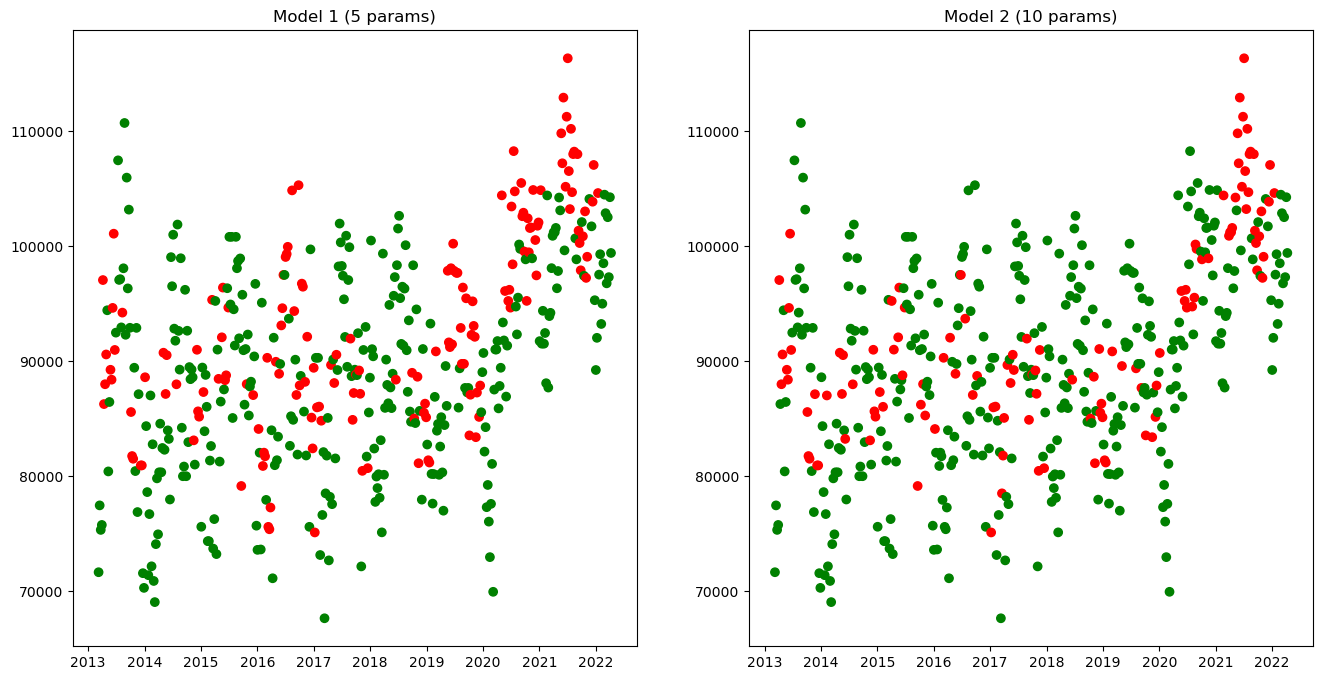

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.scatter(x=rf.index, y=rf['adj_price'], color=model_1)
ax1.set_title('Model 1 (5 params)')

ax2.scatter(x=rf.index, y=rf['adj_price'], color=model_2)
ax2.set_title('Model 2 (10 params)')

plt.show()

It looks like the models struggle with the 2022 year. Model_2 handles the limits better. Most of the incorrect predictions were in the middle of the dataset.

In [53]:
params = parameters + yearly_ratios
rf = RandomForestClassifier(min_samples_split=10, random_state=1)
rf.fit(df[params], df[target])
weighted_params = permutation_importance(rf, df[params], df[target], n_repeats=10, random_state=1)

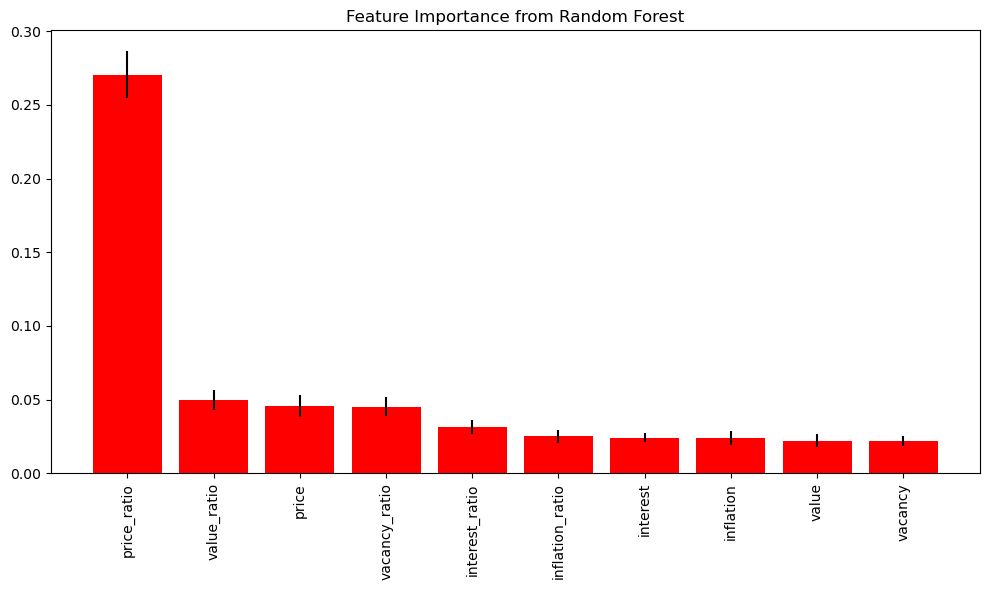

In [54]:
importances = weighted_params.importances_mean
std = weighted_params.importances_std
indices = np.argsort(importances)[::-1]
labels = [params[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(importances)), labels, rotation=90)
plt.title('Feature Importance from Random Forest')
plt.tight_layout()
plt.show()

The biggest contributing feature is price_ratio.

### Naive Bayes

In [55]:
X = df.drop(['increase'], axis=1)
y = df['increase']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [57]:
nb_model = GaussianNB()
nb_model = nb_model.fit(X_train, y_train)

In [58]:
y_pred = nb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82       104
           1       0.75      0.78      0.76        77

    accuracy                           0.80       181
   macro avg       0.79      0.79      0.79       181
weighted avg       0.80      0.80      0.80       181



### Support Vector Machines

In [59]:
svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

In [60]:
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       104
           1       0.76      0.81      0.78        77

    accuracy                           0.81       181
   macro avg       0.80      0.81      0.80       181
weighted avg       0.81      0.81      0.81       181



### Neural Network For Classification

#### Model Architecture
Three layers are added sequentially. The input dimensions will be 13. The final layer has 1 unit with a sigmoid activation function. It will use the Adam optimization algorithm. The loss function that would be best for a binary classification problem is binary cross-entropy. The evaluation metric to use for training and testing will measure accuracy.

In [61]:
DIMENSIONS = (13,)

nn_model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=DIMENSIONS),
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

nn_model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
history = nn_model_1.fit(
    X_train, y_train,
    epochs=100, batch_size=32,
    validation_split=0.2,
    verbose=0
)

In [63]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary crossentropy')
    ax1.grid(True)
    
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    
    plt.show()

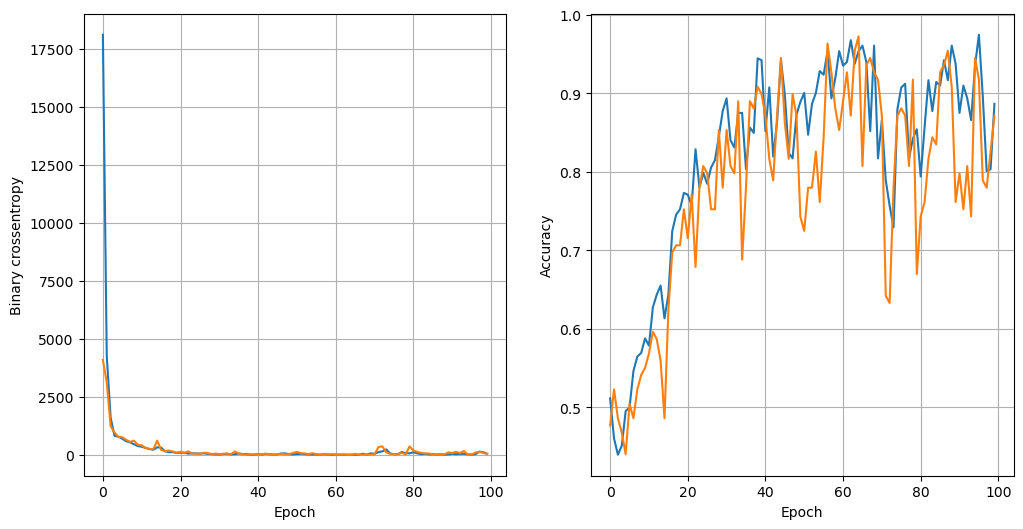

In [64]:
plot_history(history)

In [65]:
max(history.history['accuracy'])

0.9745370149612427

This is likely inaccurate. It could be due to overfitting or leakage. Testing a new network with more layers.

In [66]:
def train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs, input_dim, 
                optimizer=None, loss='binary_crossentropy', metrics=['accuracy'], 
                callbacks=None, validation_data=None, validation_split=0.2):
    if optimizer is None:
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    
    nn_model = tf.keras.Sequential([
        tf.keras.Input(shape=DIMENSIONS),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    nn_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    if validation_data:
        validation_split = 0
    
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                           validation_split=validation_split, validation_data=validation_data, 
                           verbose=0, callbacks=callbacks)
    
    return nn_model, history

16 nodes, dropout 0, learning rate 0.01, batch size 32


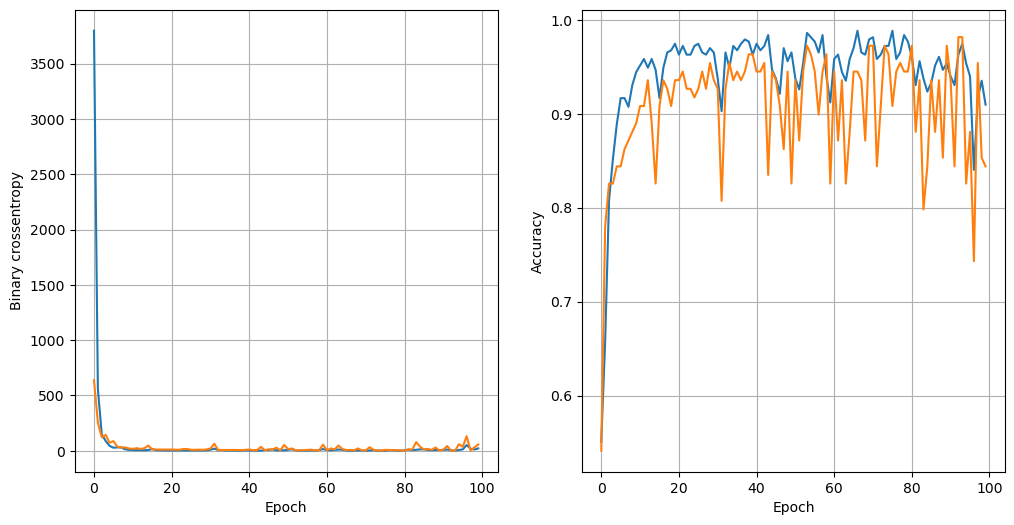

6/6 [==============================] - 0s 655us/step - loss: 66.3184 - accuracy: 0.8177
16 nodes, dropout 0, learning rate 0.01, batch size 64


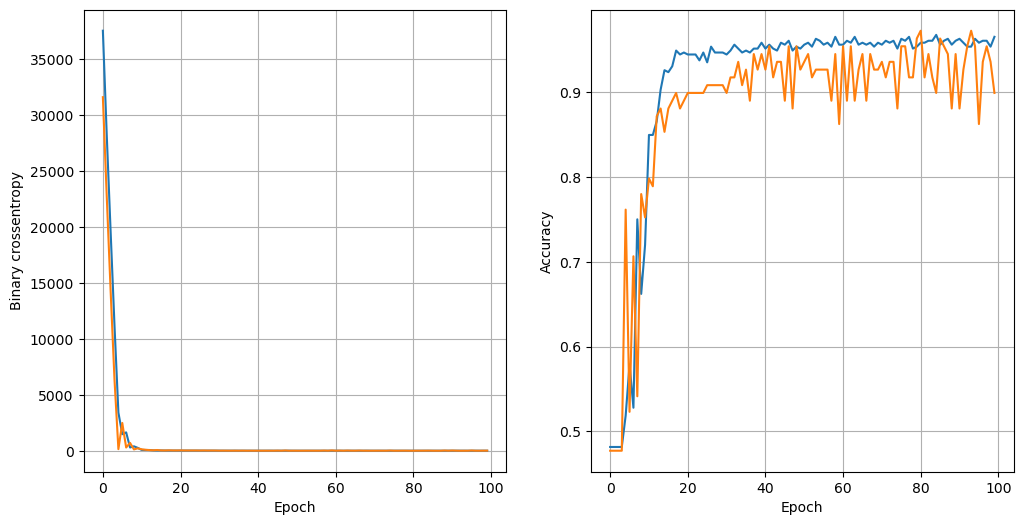

6/6 [==============================] - 0s 603us/step - loss: 4.8064 - accuracy: 0.9613
16 nodes, dropout 0, learning rate 0.01, batch size 128


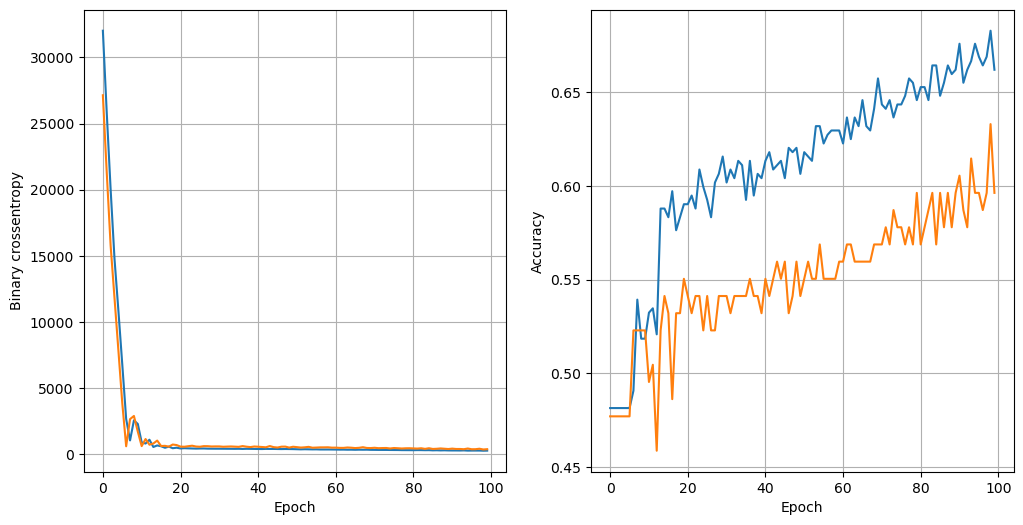

6/6 [==============================] - 0s 770us/step - loss: 355.2319 - accuracy: 0.6409
16 nodes, dropout 0, learning rate 0.005, batch size 32


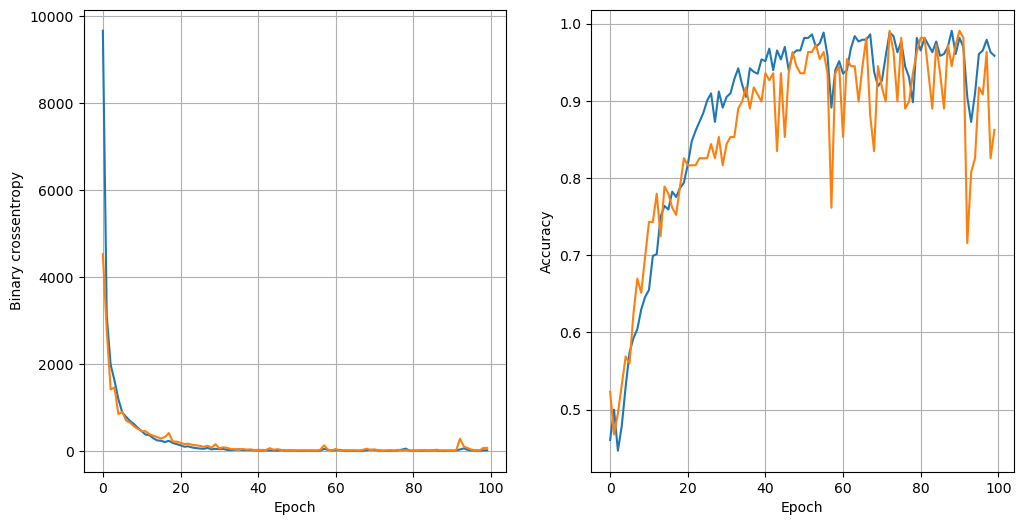

6/6 [==============================] - 0s 565us/step - loss: 82.4477 - accuracy: 0.8287
16 nodes, dropout 0, learning rate 0.005, batch size 64


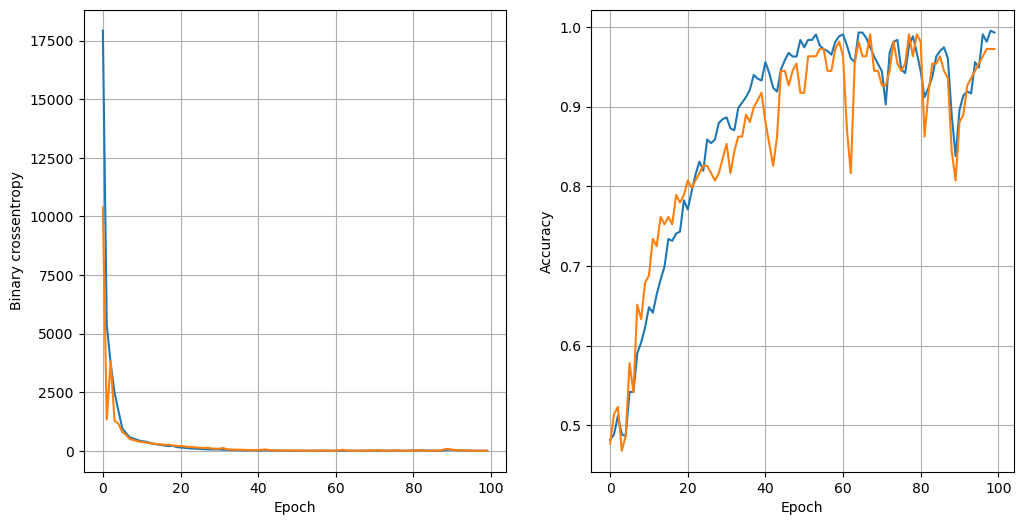

6/6 [==============================] - 0s 592us/step - loss: 1.2943 - accuracy: 0.9834
16 nodes, dropout 0, learning rate 0.005, batch size 128


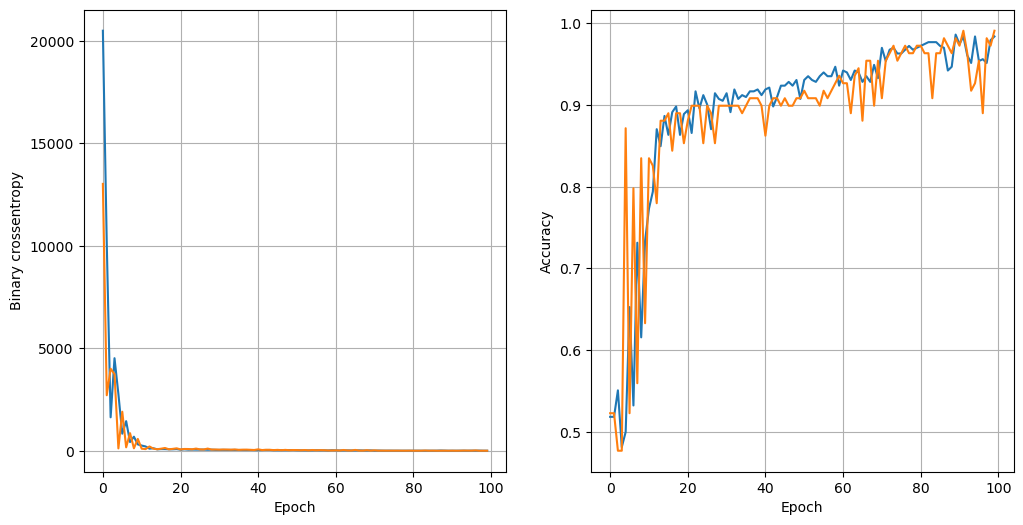

6/6 [==============================] - 0s 679us/step - loss: 0.4778 - accuracy: 0.9890
16 nodes, dropout 0, learning rate 0.001, batch size 32


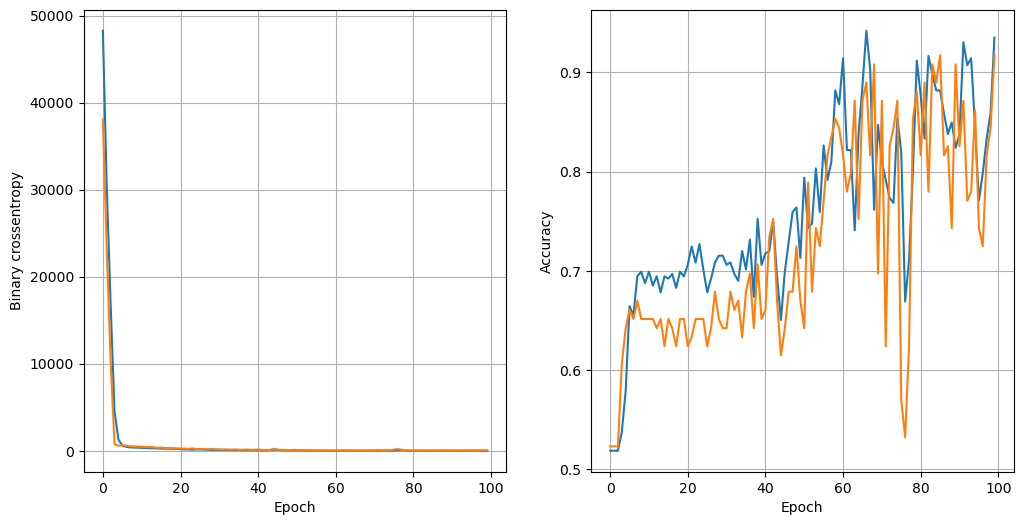

6/6 [==============================] - 0s 588us/step - loss: 13.9436 - accuracy: 0.9227
16 nodes, dropout 0, learning rate 0.001, batch size 64


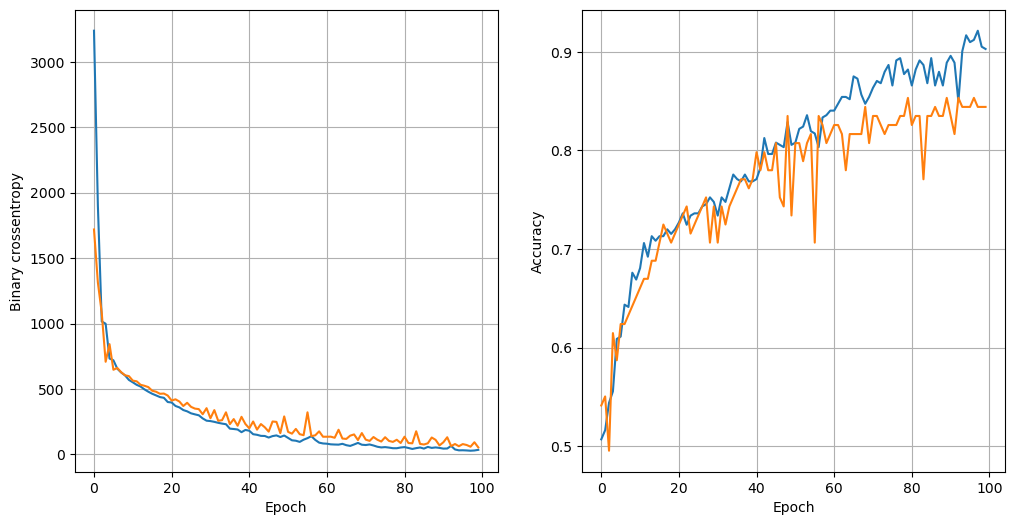

6/6 [==============================] - 0s 516us/step - loss: 32.8979 - accuracy: 0.8564
16 nodes, dropout 0, learning rate 0.001, batch size 128


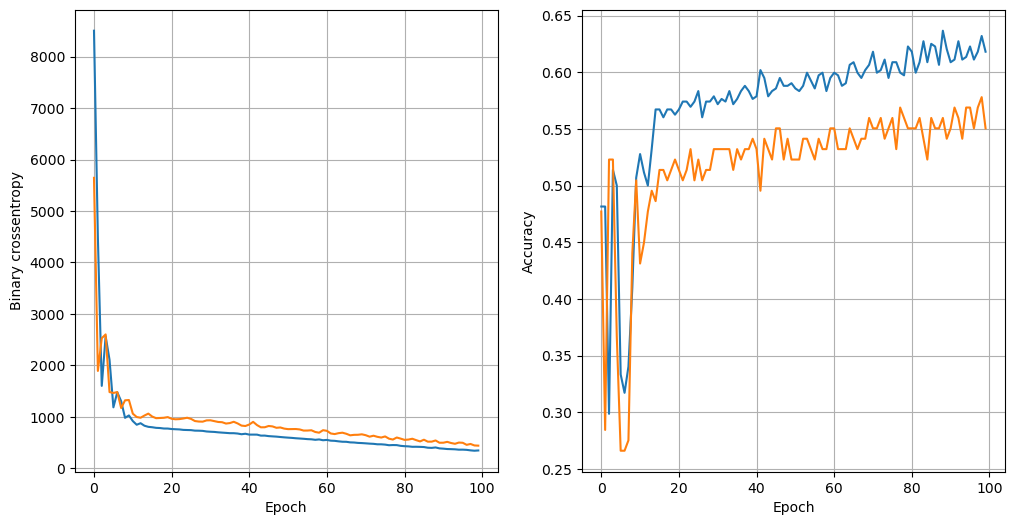

6/6 [==============================] - 0s 660us/step - loss: 427.7910 - accuracy: 0.6188
16 nodes, dropout 0.2, learning rate 0.01, batch size 32


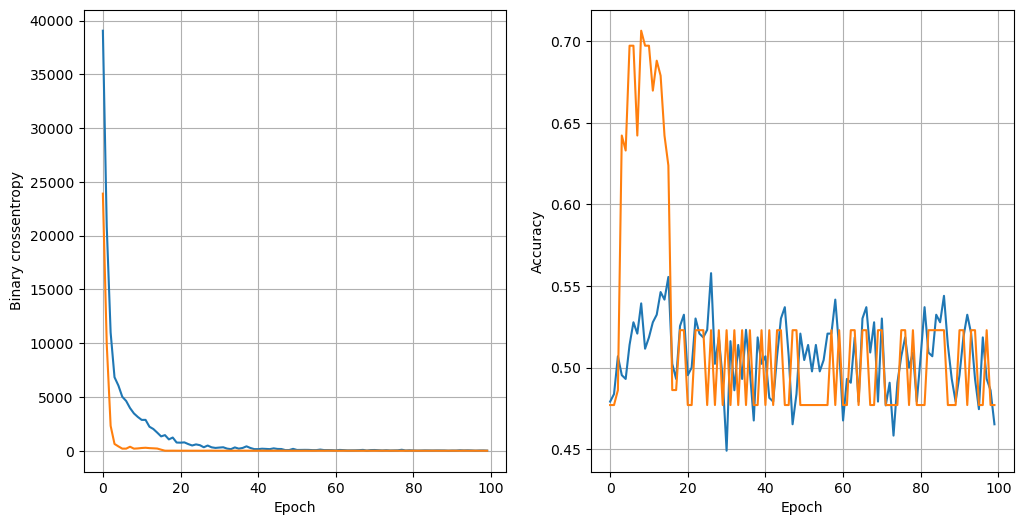

6/6 [==============================] - 0s 640us/step - loss: 0.7918 - accuracy: 0.5746
16 nodes, dropout 0.2, learning rate 0.01, batch size 64


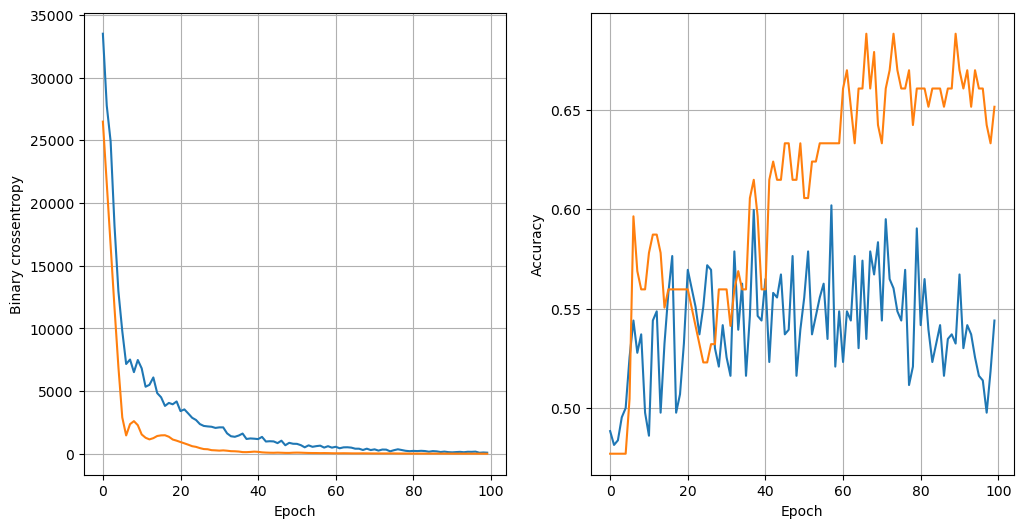

6/6 [==============================] - 0s 645us/step - loss: 17.2886 - accuracy: 0.6409
16 nodes, dropout 0.2, learning rate 0.01, batch size 128


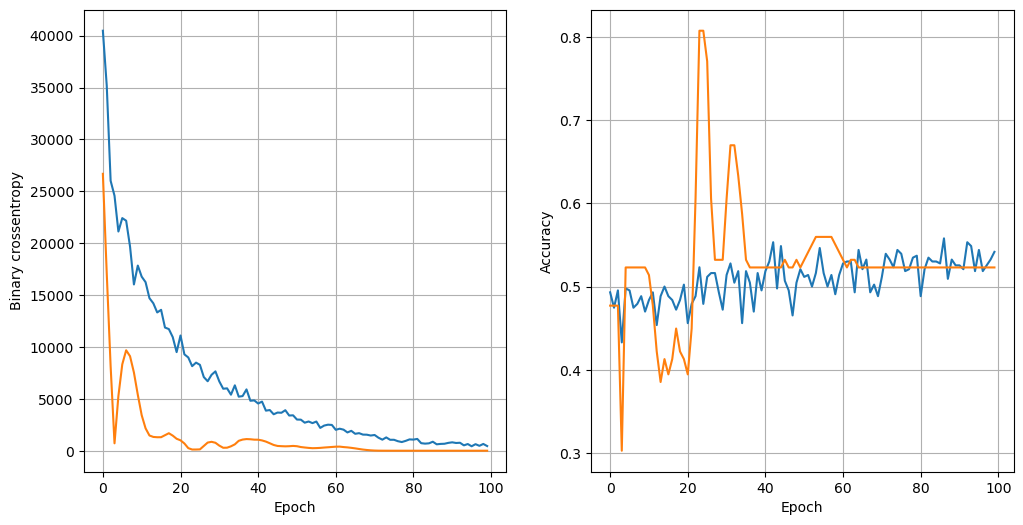

6/6 [==============================] - 0s 834us/step - loss: 0.6950 - accuracy: 0.4254
16 nodes, dropout 0.2, learning rate 0.005, batch size 32


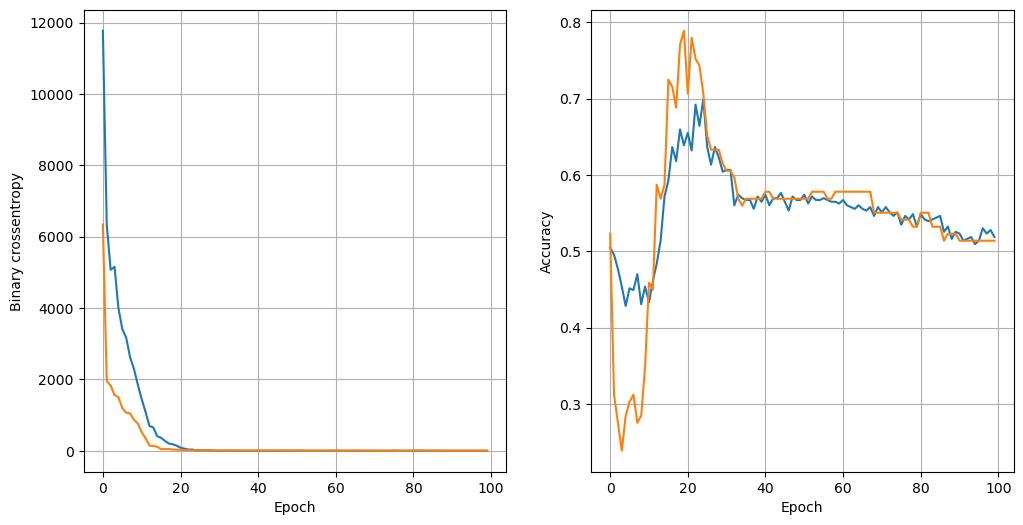

6/6 [==============================] - 0s 827us/step - loss: 0.6794 - accuracy: 0.6077
16 nodes, dropout 0.2, learning rate 0.005, batch size 64


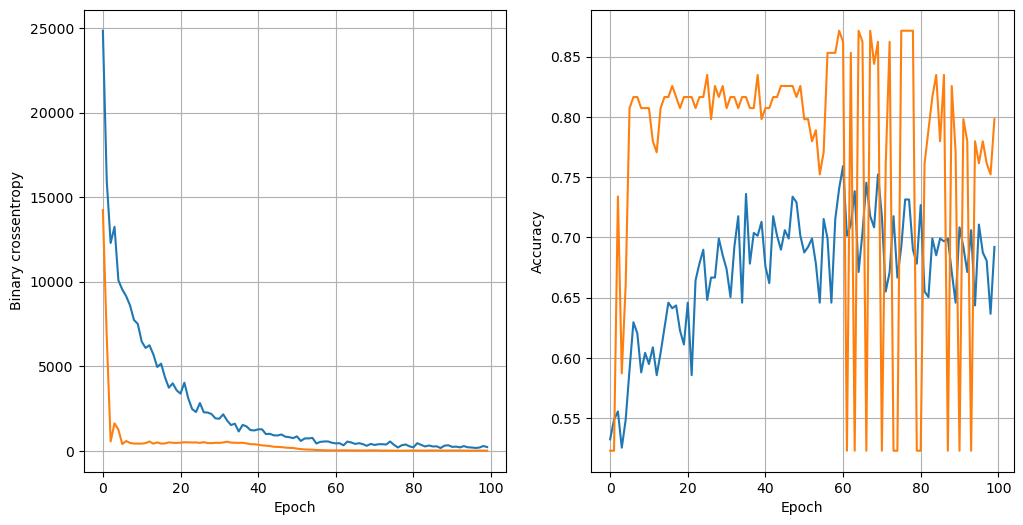

6/6 [==============================] - 0s 646us/step - loss: 0.5426 - accuracy: 0.7680
16 nodes, dropout 0.2, learning rate 0.005, batch size 128


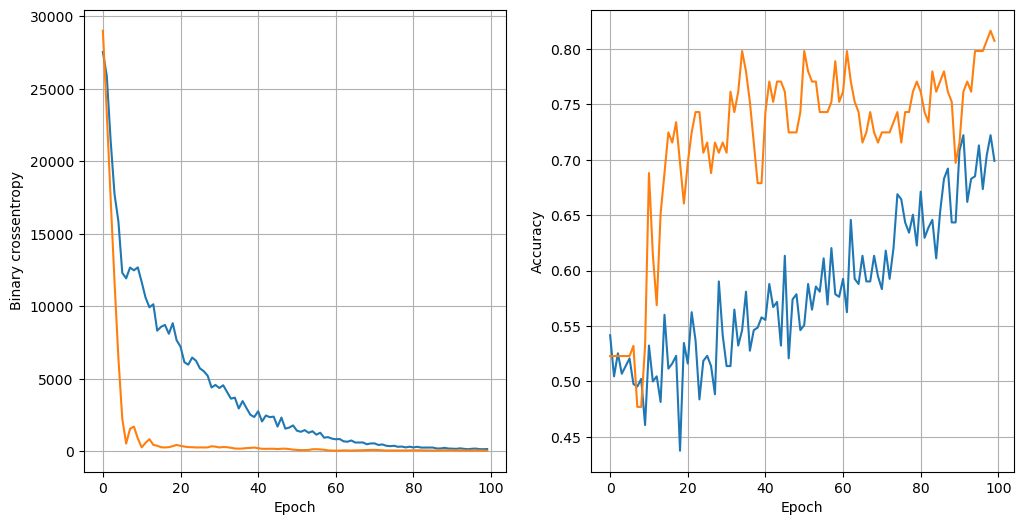

6/6 [==============================] - 0s 610us/step - loss: 54.7184 - accuracy: 0.7845
16 nodes, dropout 0.2, learning rate 0.001, batch size 32


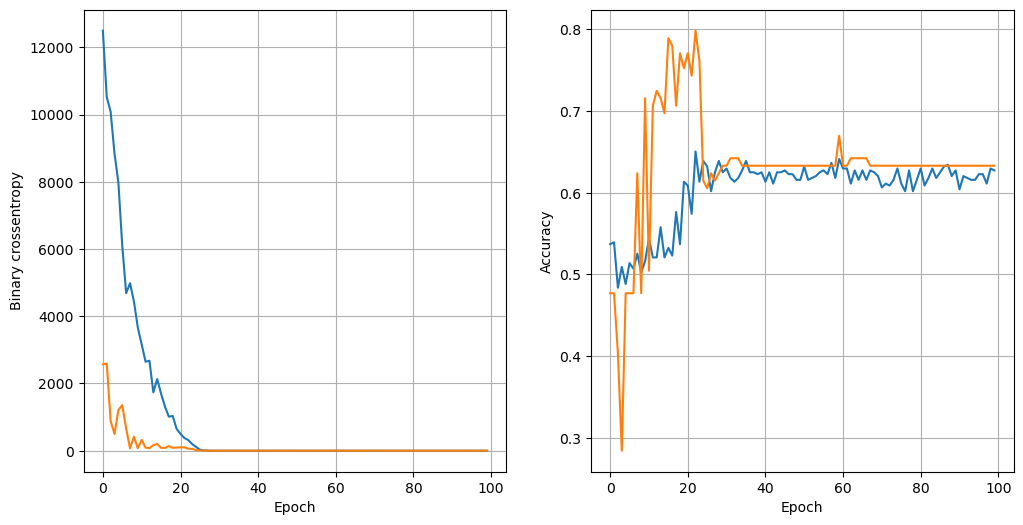

6/6 [==============================] - 0s 643us/step - loss: 4.1178 - accuracy: 0.6796
16 nodes, dropout 0.2, learning rate 0.001, batch size 64


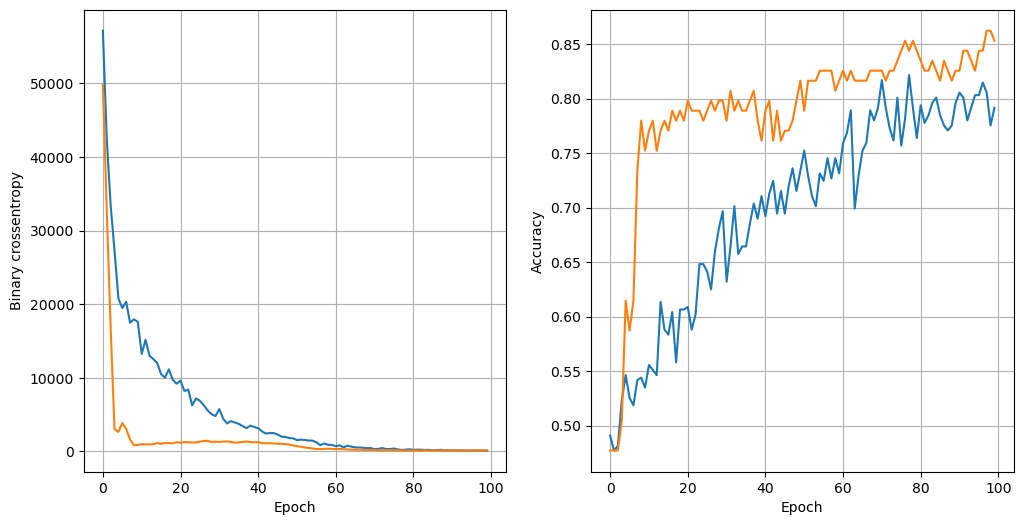

6/6 [==============================] - 0s 621us/step - loss: 76.3563 - accuracy: 0.8619
16 nodes, dropout 0.2, learning rate 0.001, batch size 128


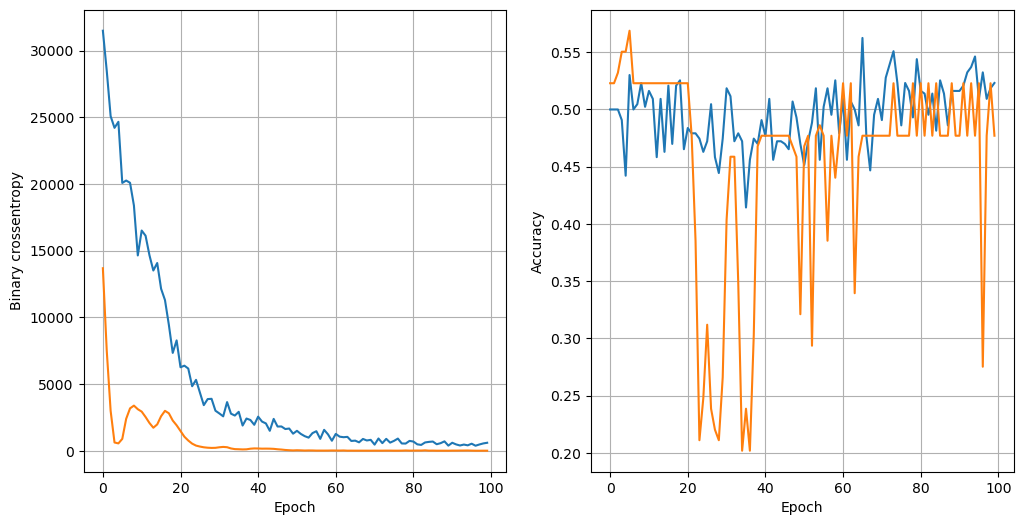

6/6 [==============================] - 0s 707us/step - loss: 1.7486 - accuracy: 0.5746
32 nodes, dropout 0, learning rate 0.01, batch size 32


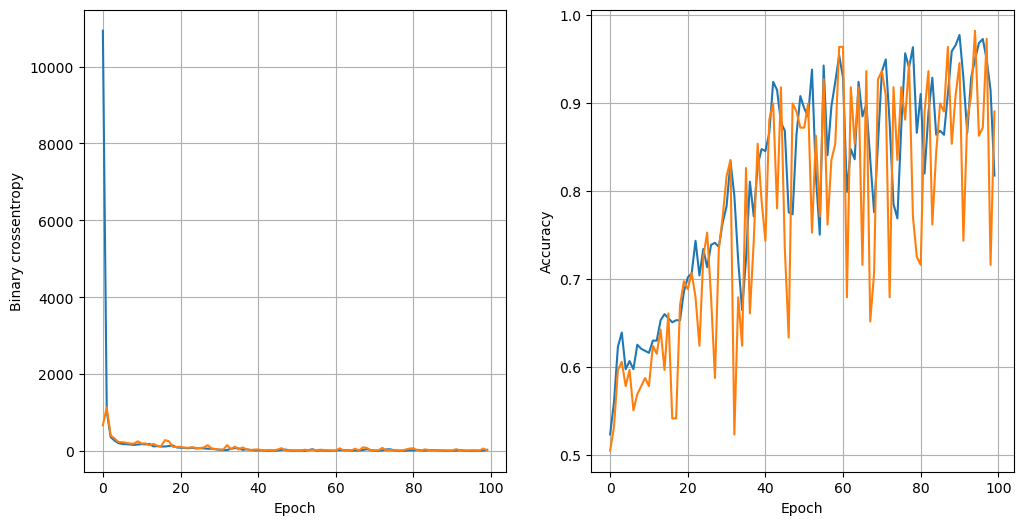

6/6 [==============================] - 0s 627us/step - loss: 10.9071 - accuracy: 0.8508
32 nodes, dropout 0, learning rate 0.01, batch size 64


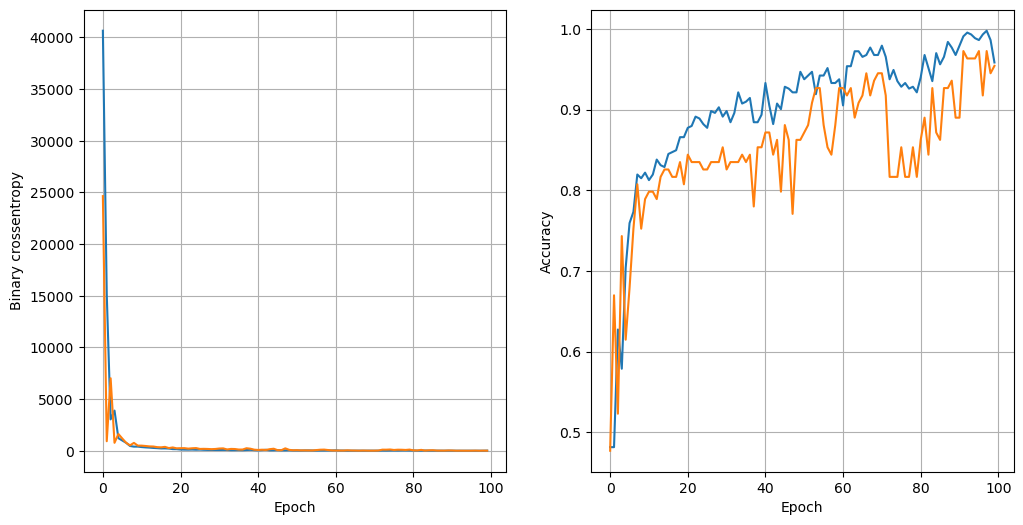

6/6 [==============================] - 0s 604us/step - loss: 4.2514 - accuracy: 0.9724
32 nodes, dropout 0, learning rate 0.01, batch size 128


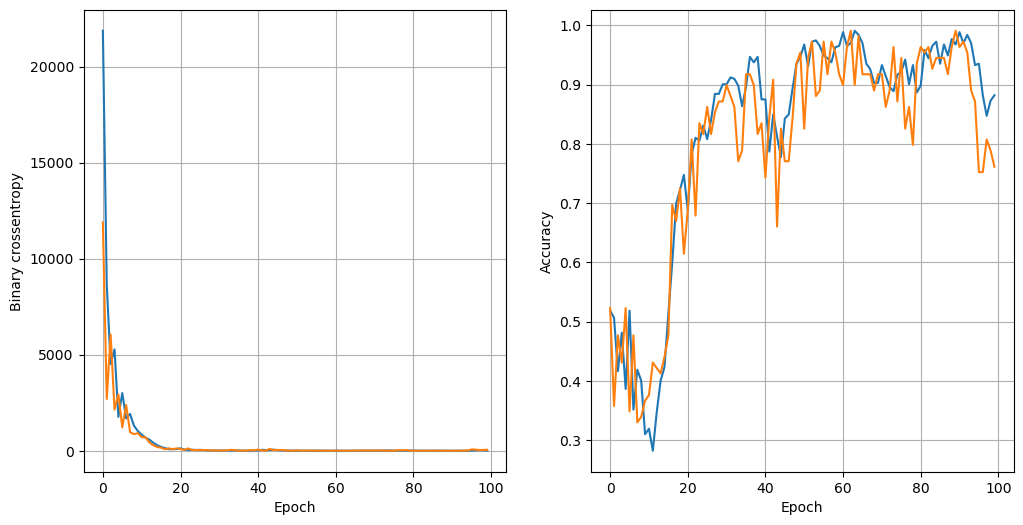

6/6 [==============================] - 0s 653us/step - loss: 36.1060 - accuracy: 0.7790
32 nodes, dropout 0, learning rate 0.005, batch size 32


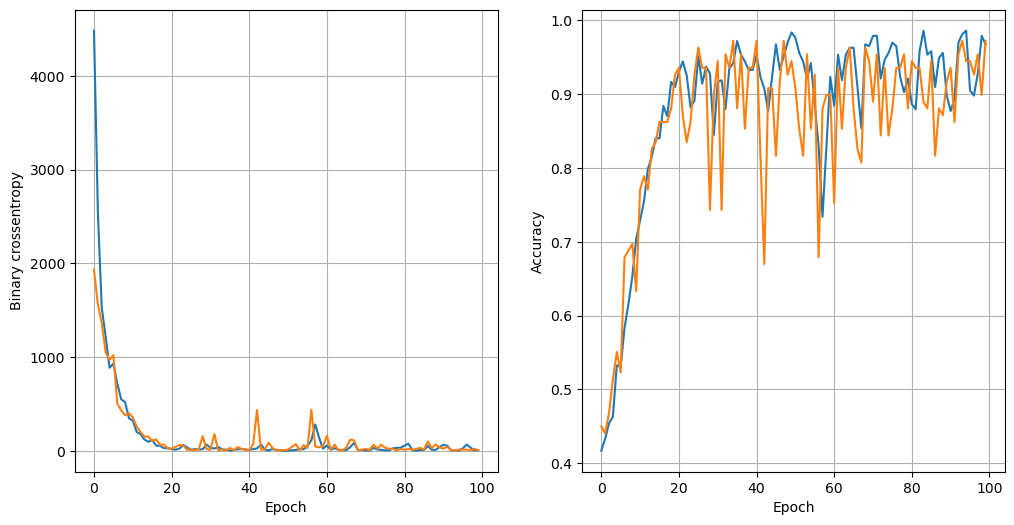

6/6 [==============================] - 0s 618us/step - loss: 0.5572 - accuracy: 0.9890
32 nodes, dropout 0, learning rate 0.005, batch size 64


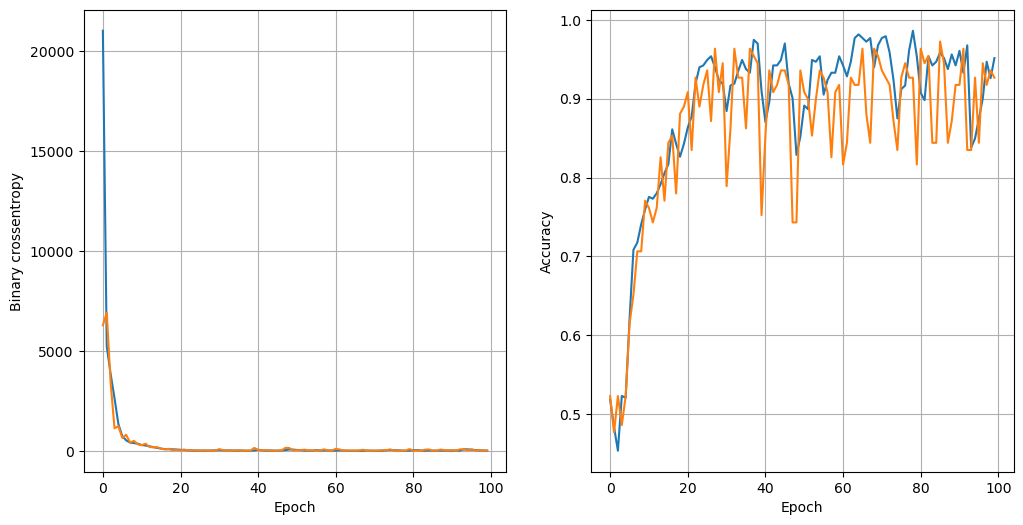

6/6 [==============================] - 0s 598us/step - loss: 0.8362 - accuracy: 0.9834
32 nodes, dropout 0, learning rate 0.005, batch size 128


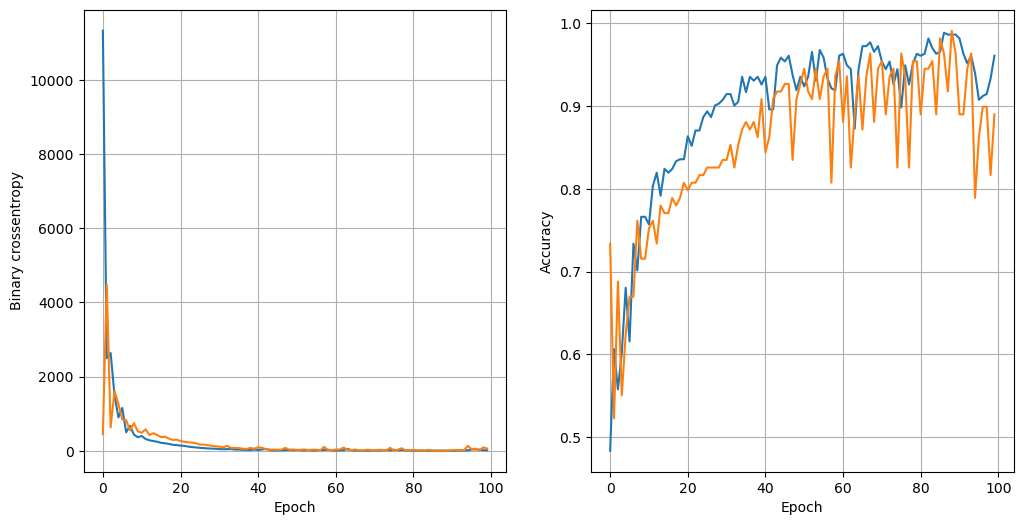

6/6 [==============================] - 0s 658us/step - loss: 69.2775 - accuracy: 0.8508
32 nodes, dropout 0, learning rate 0.001, batch size 32


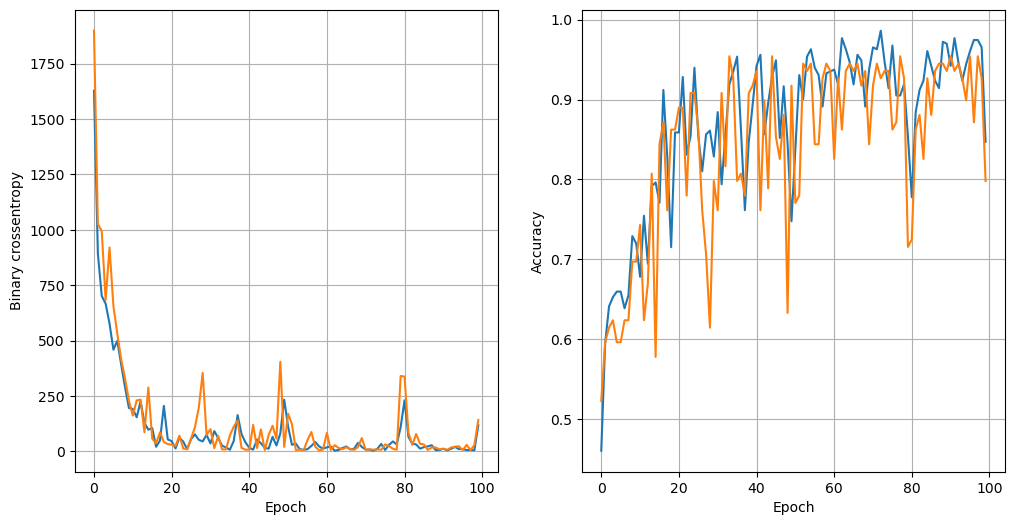

6/6 [==============================] - 0s 530us/step - loss: 87.7361 - accuracy: 0.8066
32 nodes, dropout 0, learning rate 0.001, batch size 64


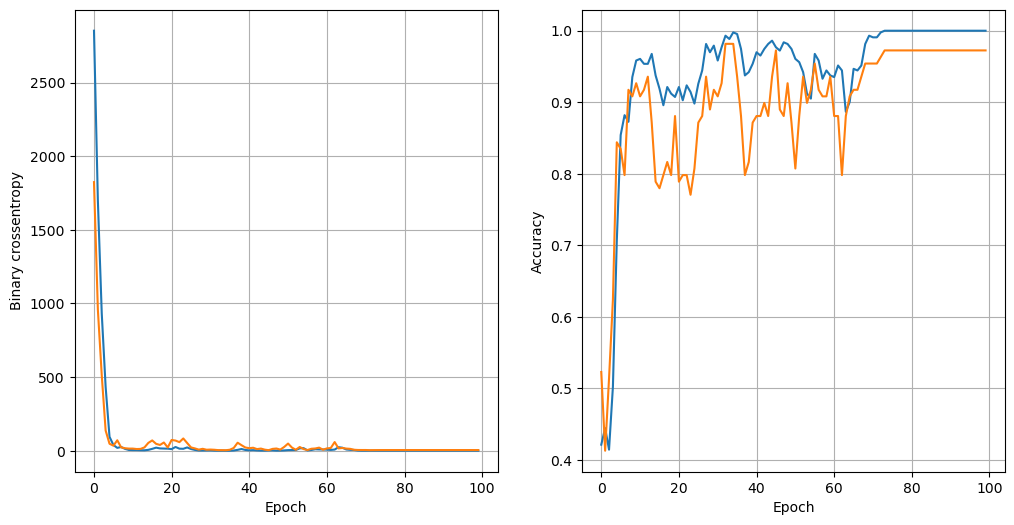

6/6 [==============================] - 0s 501us/step - loss: 1.1265 - accuracy: 0.9779
32 nodes, dropout 0, learning rate 0.001, batch size 128


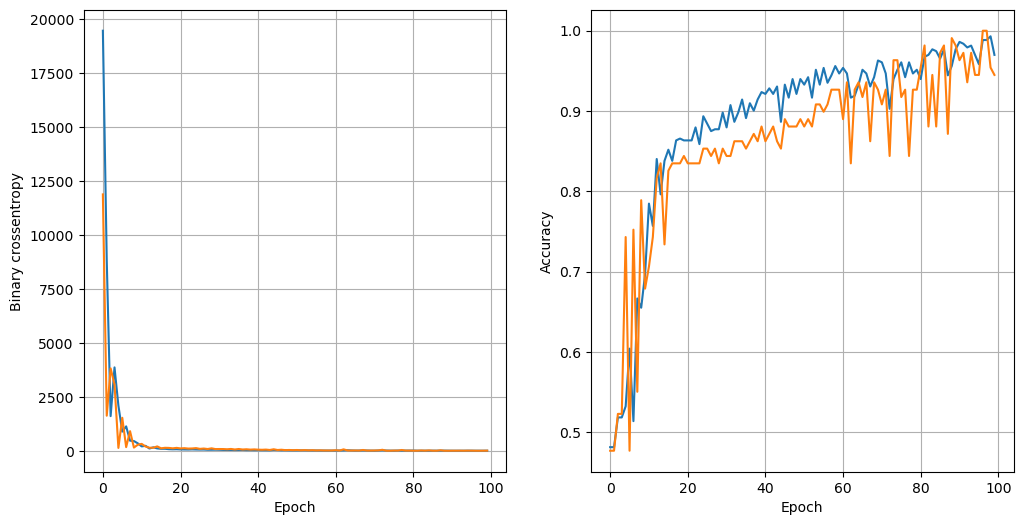

6/6 [==============================] - 0s 561us/step - loss: 4.4580 - accuracy: 0.9503
32 nodes, dropout 0.2, learning rate 0.01, batch size 32


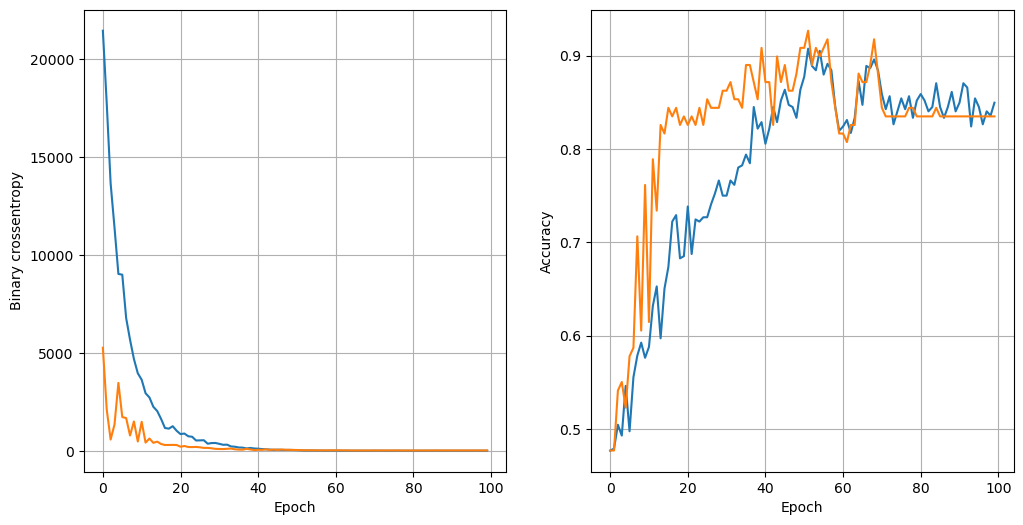

6/6 [==============================] - 0s 494us/step - loss: 5.8339 - accuracy: 0.8674
32 nodes, dropout 0.2, learning rate 0.01, batch size 64


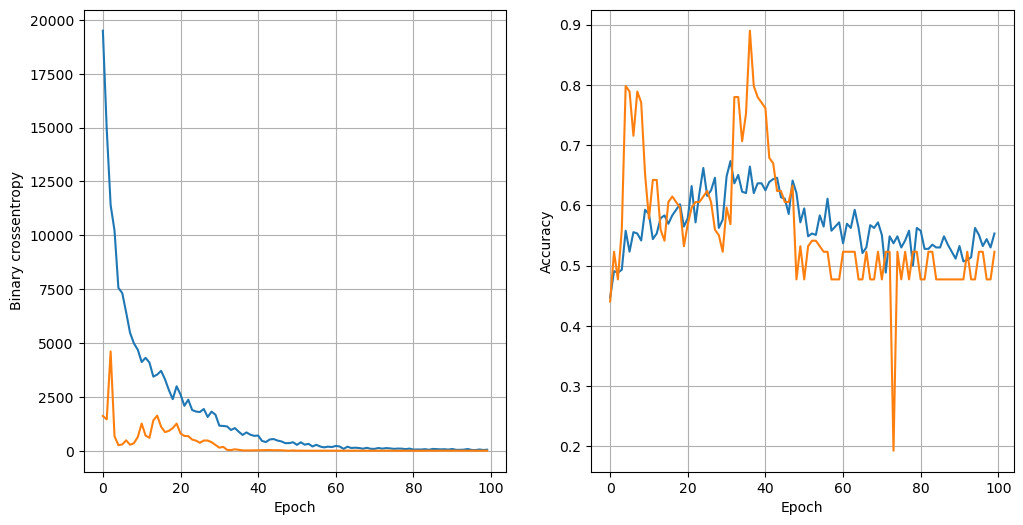

6/6 [==============================] - 0s 585us/step - loss: 2.3269 - accuracy: 0.4254
32 nodes, dropout 0.2, learning rate 0.01, batch size 128


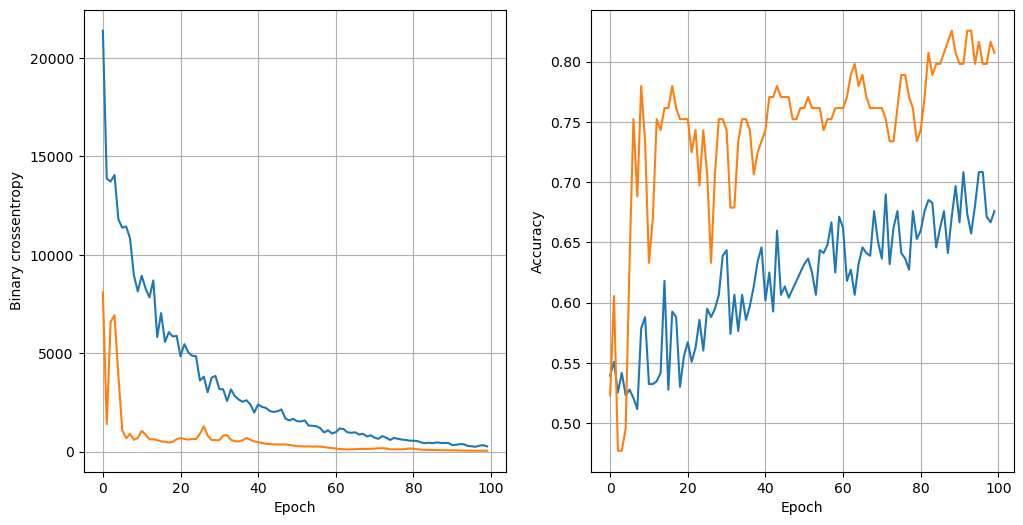

6/6 [==============================] - 0s 544us/step - loss: 45.0329 - accuracy: 0.8343
32 nodes, dropout 0.2, learning rate 0.005, batch size 32


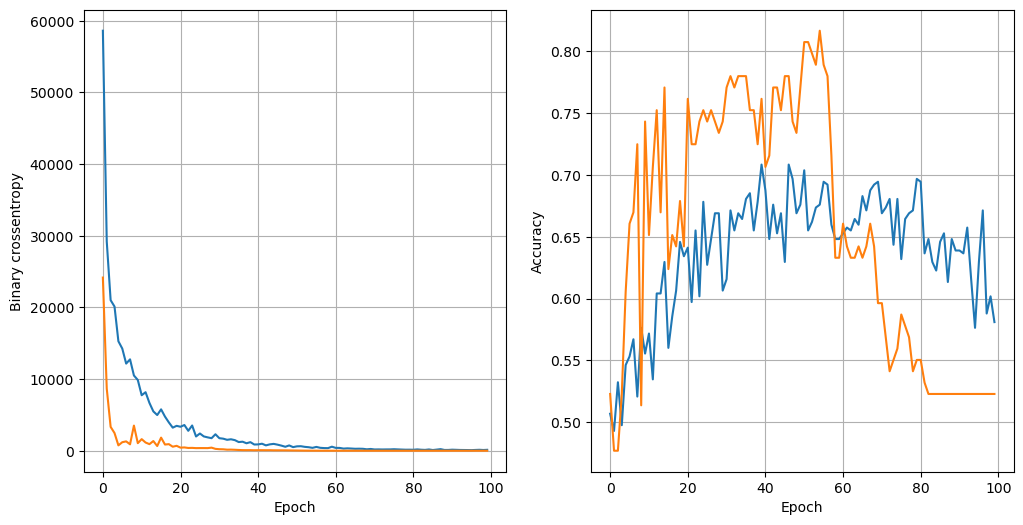

6/6 [==============================] - 0s 559us/step - loss: 0.7123 - accuracy: 0.4254
32 nodes, dropout 0.2, learning rate 0.005, batch size 64


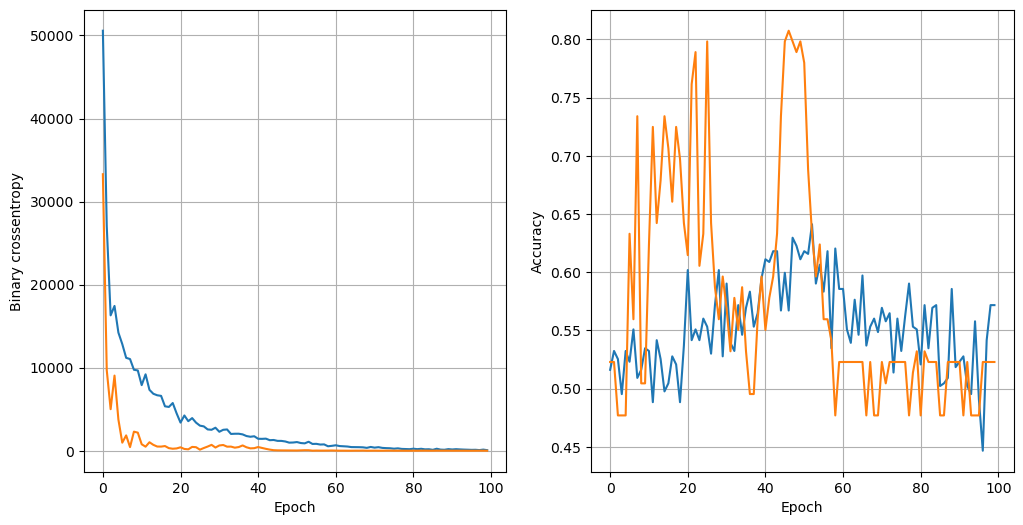

6/6 [==============================] - 0s 572us/step - loss: 2.2675 - accuracy: 0.4254
32 nodes, dropout 0.2, learning rate 0.005, batch size 128


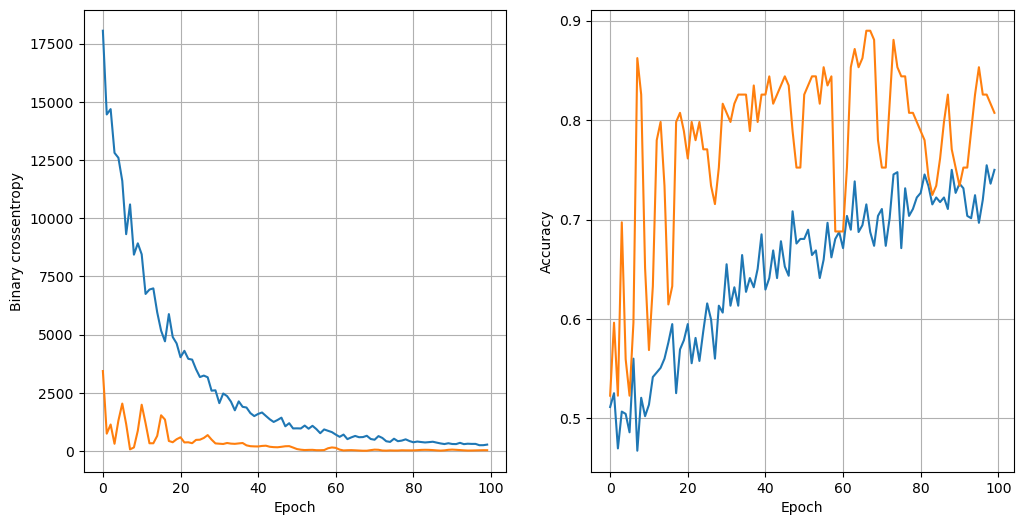

6/6 [==============================] - 0s 652us/step - loss: 27.0146 - accuracy: 0.8398
32 nodes, dropout 0.2, learning rate 0.001, batch size 32


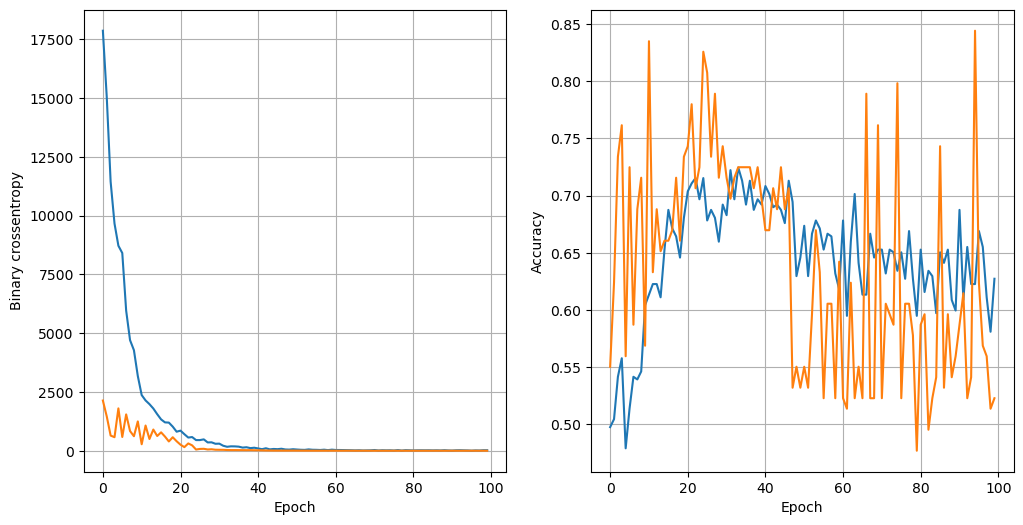

6/6 [==============================] - 0s 559us/step - loss: 0.9374 - accuracy: 0.4420
32 nodes, dropout 0.2, learning rate 0.001, batch size 64


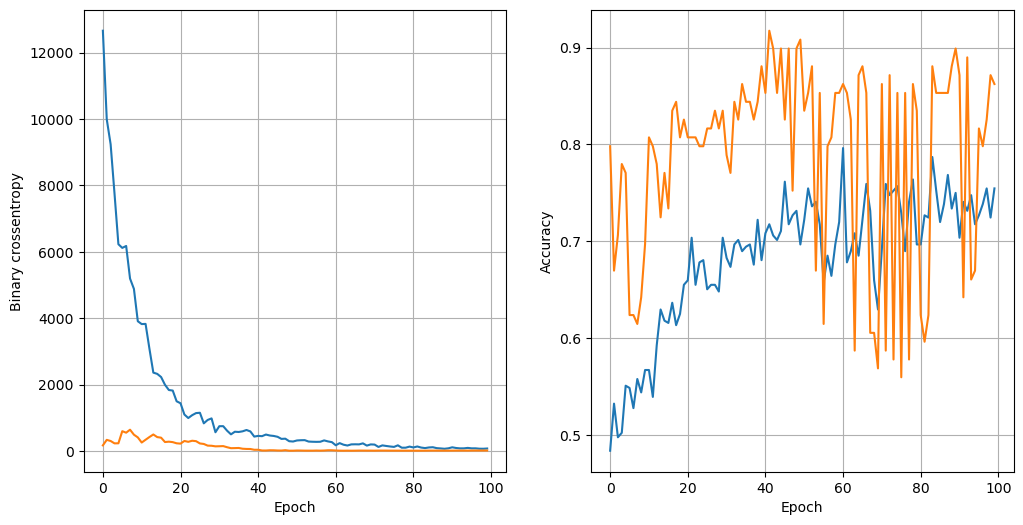

6/6 [==============================] - 0s 561us/step - loss: 5.8675 - accuracy: 0.8729
32 nodes, dropout 0.2, learning rate 0.001, batch size 128


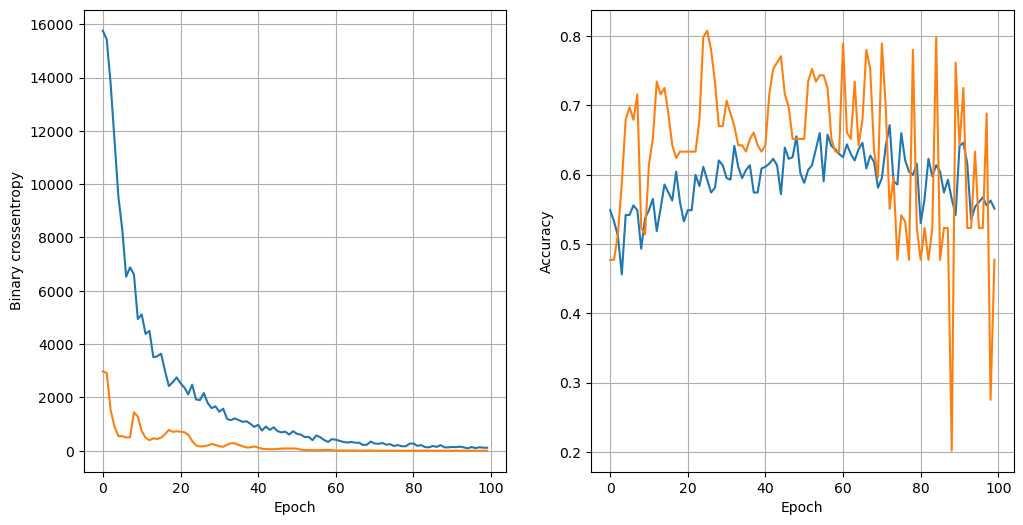

6/6 [==============================] - 0s 527us/step - loss: 1.1249 - accuracy: 0.5746
64 nodes, dropout 0, learning rate 0.01, batch size 32


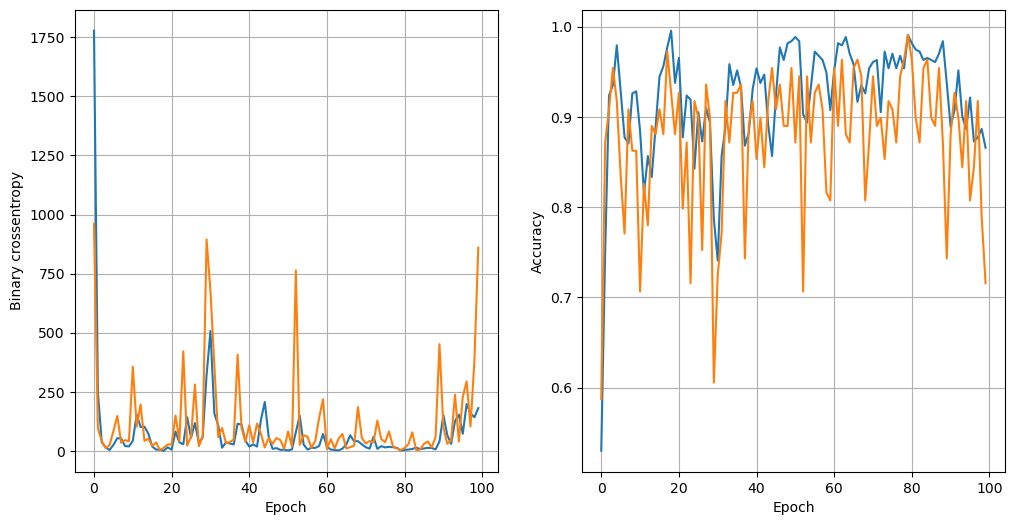

6/6 [==============================] - 0s 554us/step - loss: 703.6077 - accuracy: 0.6630
64 nodes, dropout 0, learning rate 0.01, batch size 64


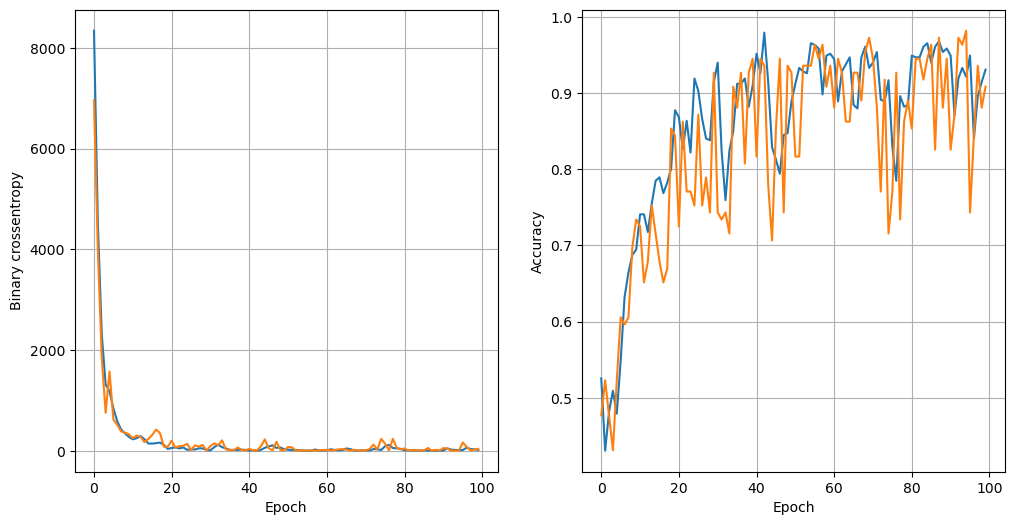

6/6 [==============================] - 0s 527us/step - loss: 41.8824 - accuracy: 0.8508
64 nodes, dropout 0, learning rate 0.01, batch size 128


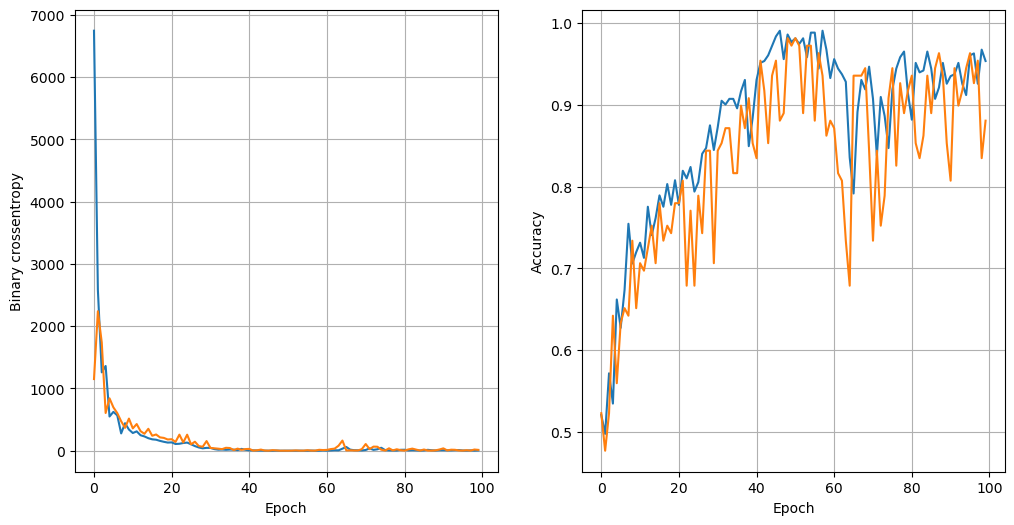

6/6 [==============================] - 0s 552us/step - loss: 6.2643 - accuracy: 0.9171
64 nodes, dropout 0, learning rate 0.005, batch size 32


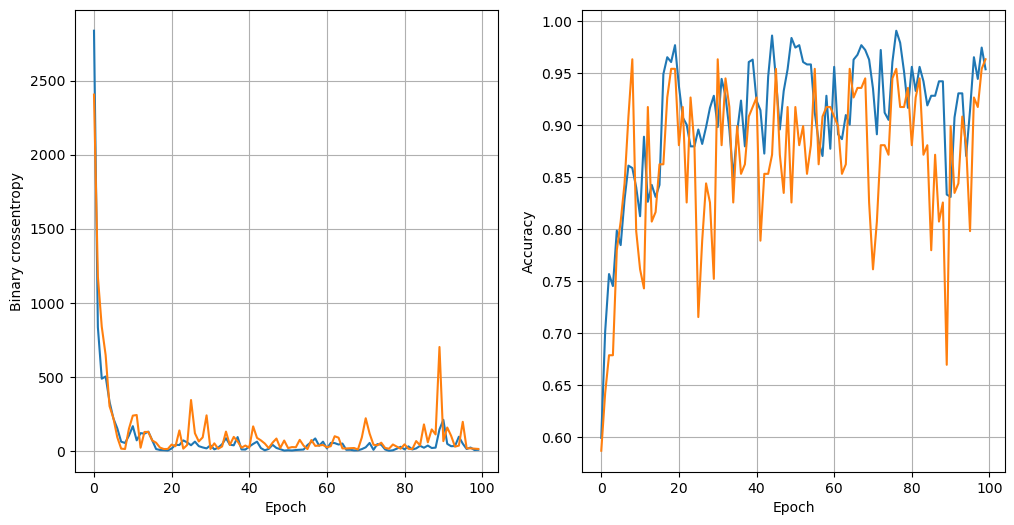

6/6 [==============================] - 0s 537us/step - loss: 3.1579 - accuracy: 0.9834
64 nodes, dropout 0, learning rate 0.005, batch size 64


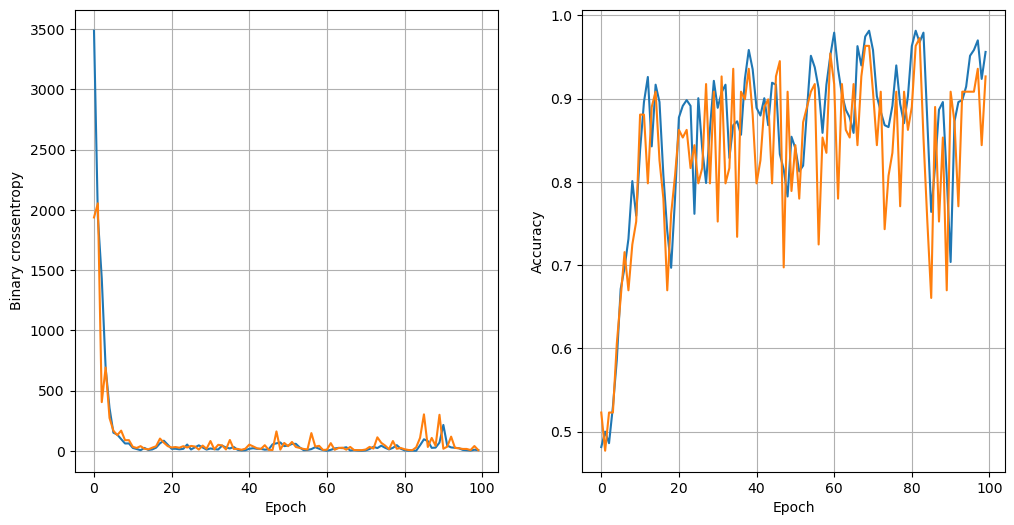

6/6 [==============================] - 0s 571us/step - loss: 4.4659 - accuracy: 0.9613
64 nodes, dropout 0, learning rate 0.005, batch size 128


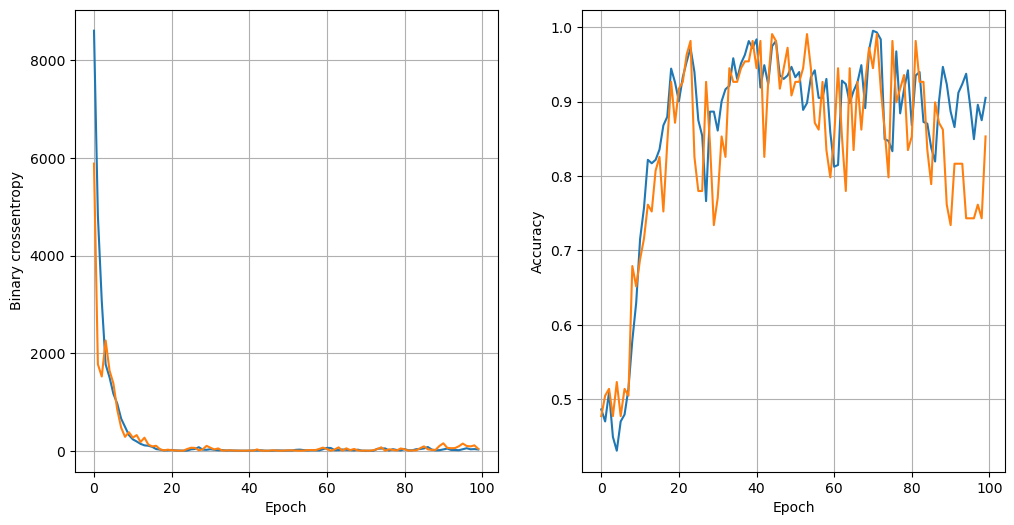

6/6 [==============================] - 0s 502us/step - loss: 16.8807 - accuracy: 0.9006
64 nodes, dropout 0, learning rate 0.001, batch size 32


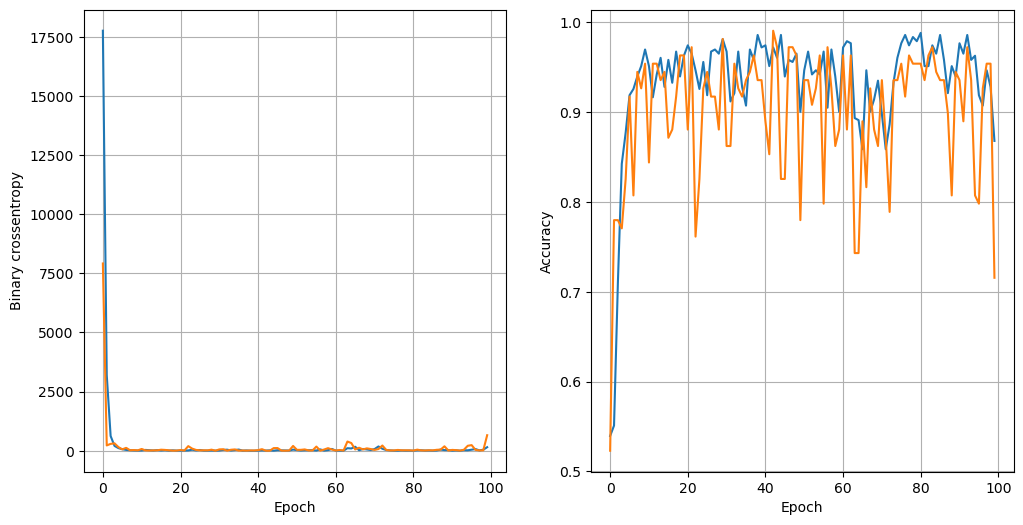

6/6 [==============================] - 0s 562us/step - loss: 587.3016 - accuracy: 0.6464
64 nodes, dropout 0, learning rate 0.001, batch size 64


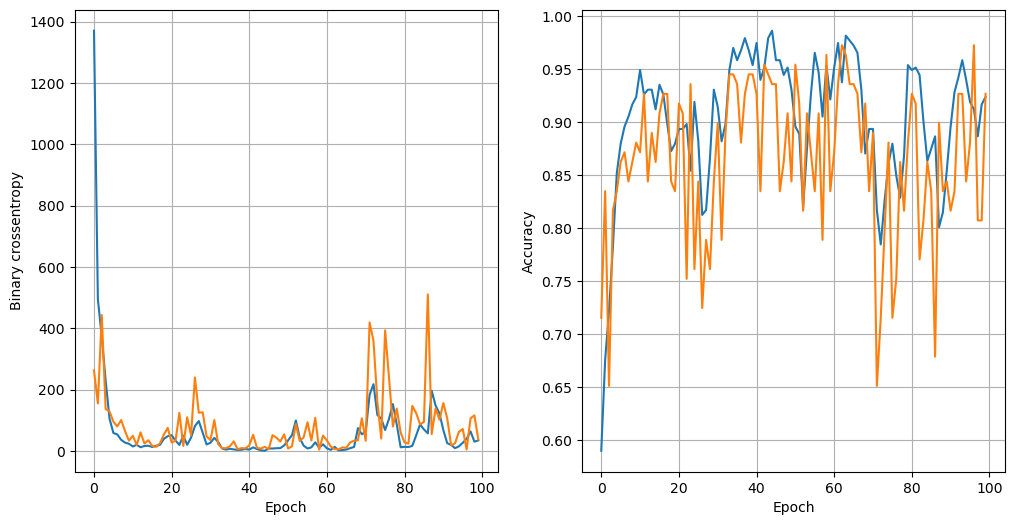

6/6 [==============================] - 0s 526us/step - loss: 37.6758 - accuracy: 0.8895
64 nodes, dropout 0, learning rate 0.001, batch size 128


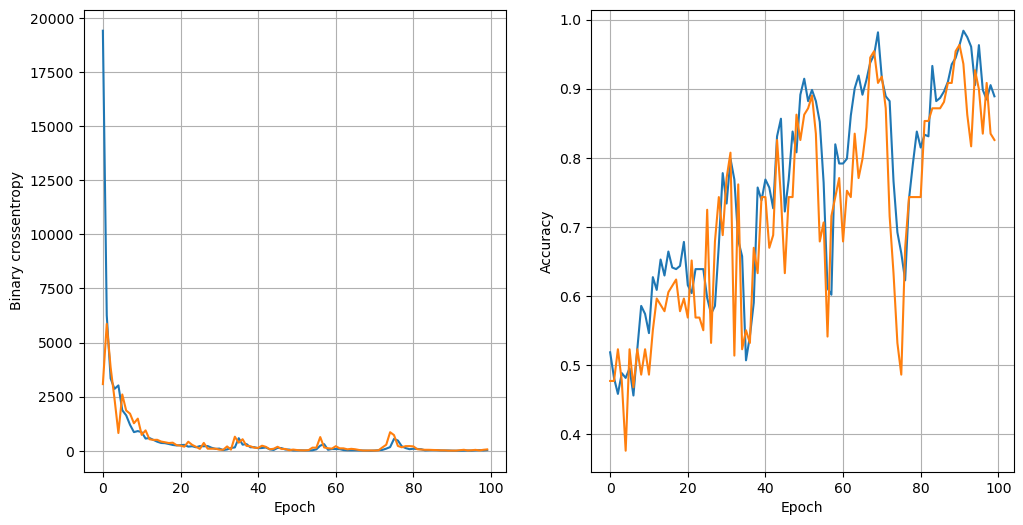

6/6 [==============================] - 0s 514us/step - loss: 68.5017 - accuracy: 0.8011
64 nodes, dropout 0.2, learning rate 0.01, batch size 32


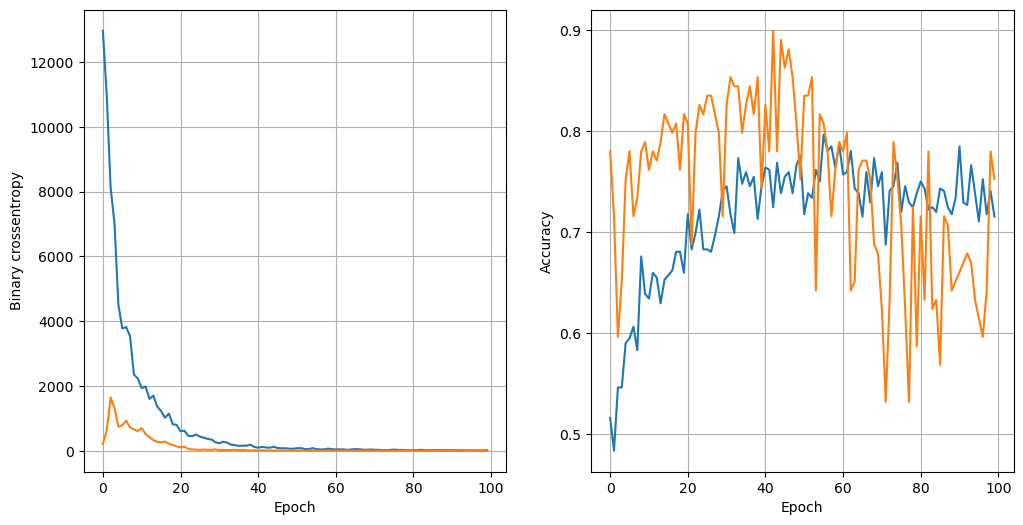

6/6 [==============================] - 0s 560us/step - loss: 0.4511 - accuracy: 0.7348
64 nodes, dropout 0.2, learning rate 0.01, batch size 64


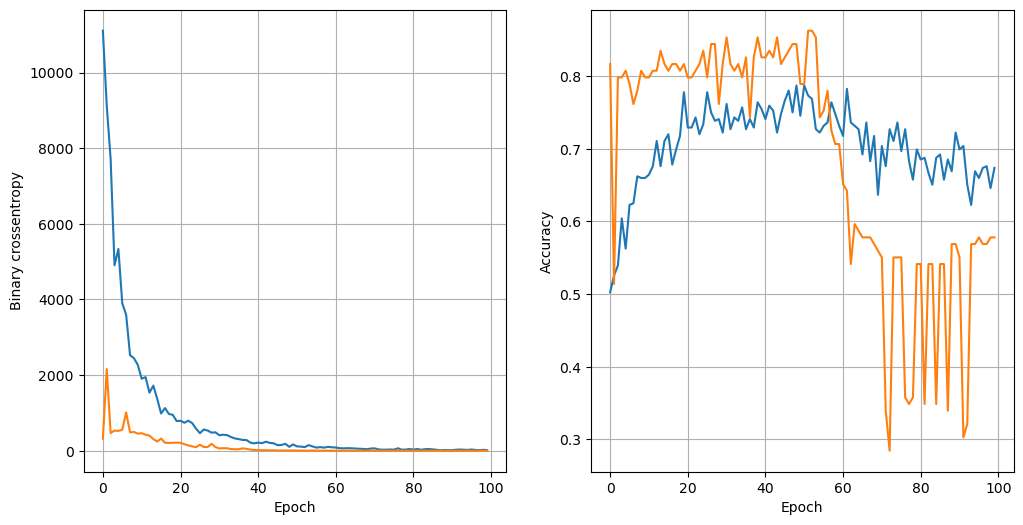

6/6 [==============================] - 0s 538us/step - loss: 0.6348 - accuracy: 0.4586
64 nodes, dropout 0.2, learning rate 0.01, batch size 128


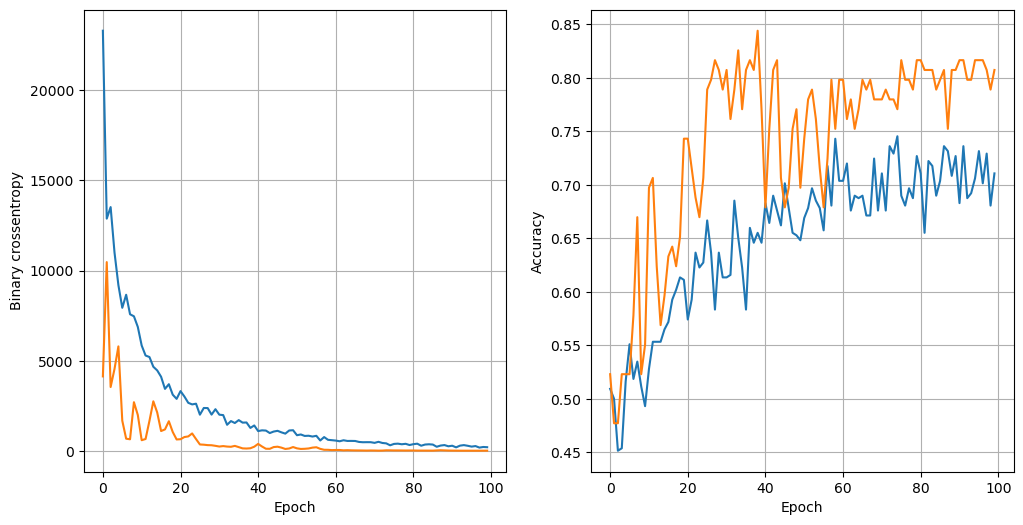

6/6 [==============================] - 0s 609us/step - loss: 25.8969 - accuracy: 0.8011
64 nodes, dropout 0.2, learning rate 0.005, batch size 32


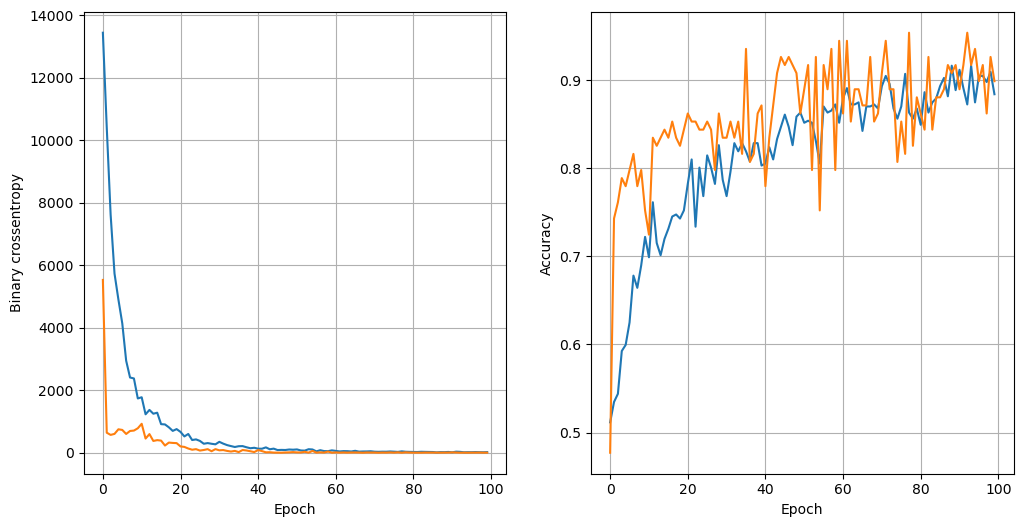

6/6 [==============================] - 0s 528us/step - loss: 1.6095 - accuracy: 0.9392
64 nodes, dropout 0.2, learning rate 0.005, batch size 64


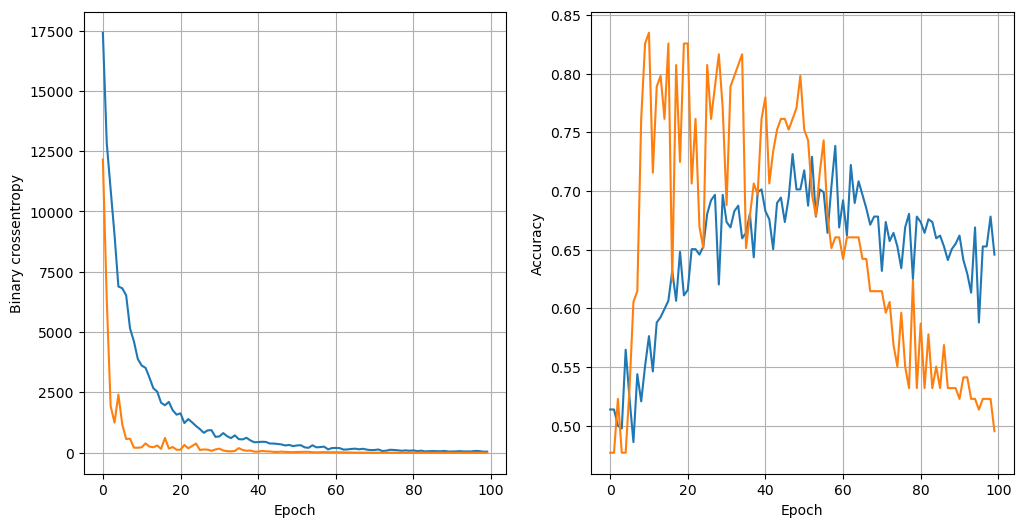

6/6 [==============================] - 0s 548us/step - loss: 0.6918 - accuracy: 0.5967
64 nodes, dropout 0.2, learning rate 0.005, batch size 128


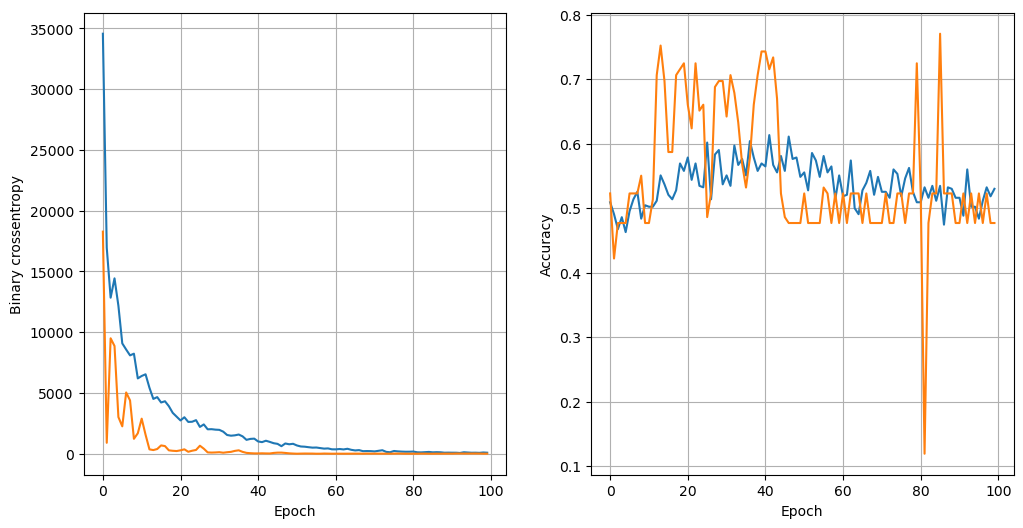

6/6 [==============================] - 0s 513us/step - loss: 4.9895 - accuracy: 0.5746
64 nodes, dropout 0.2, learning rate 0.001, batch size 32


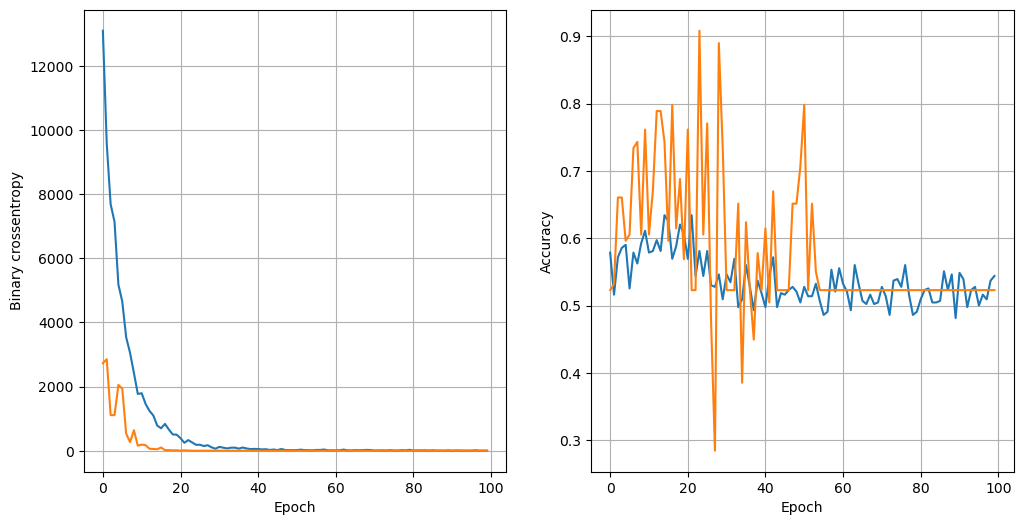

6/6 [==============================] - 0s 558us/step - loss: 0.6970 - accuracy: 0.4254
64 nodes, dropout 0.2, learning rate 0.001, batch size 64


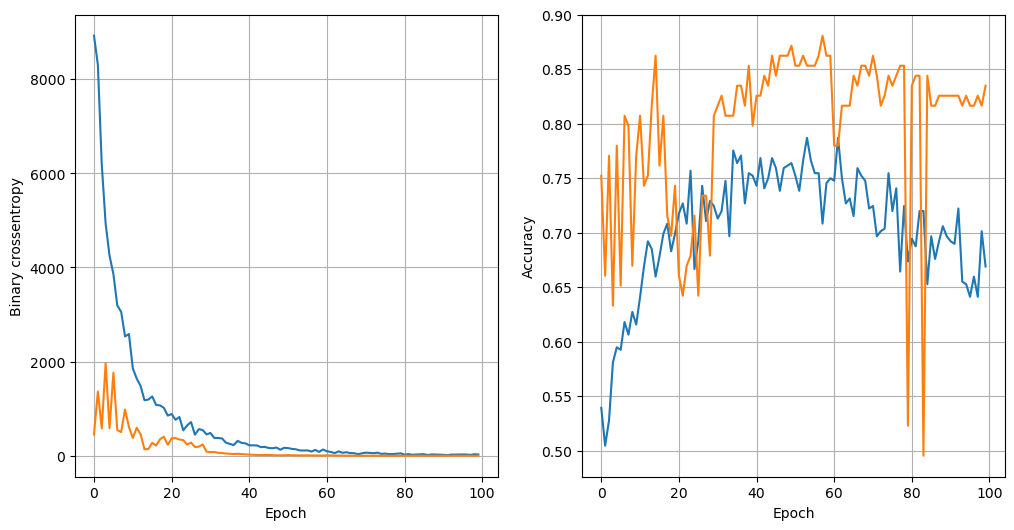

6/6 [==============================] - 0s 526us/step - loss: 0.6567 - accuracy: 0.8785
64 nodes, dropout 0.2, learning rate 0.001, batch size 128


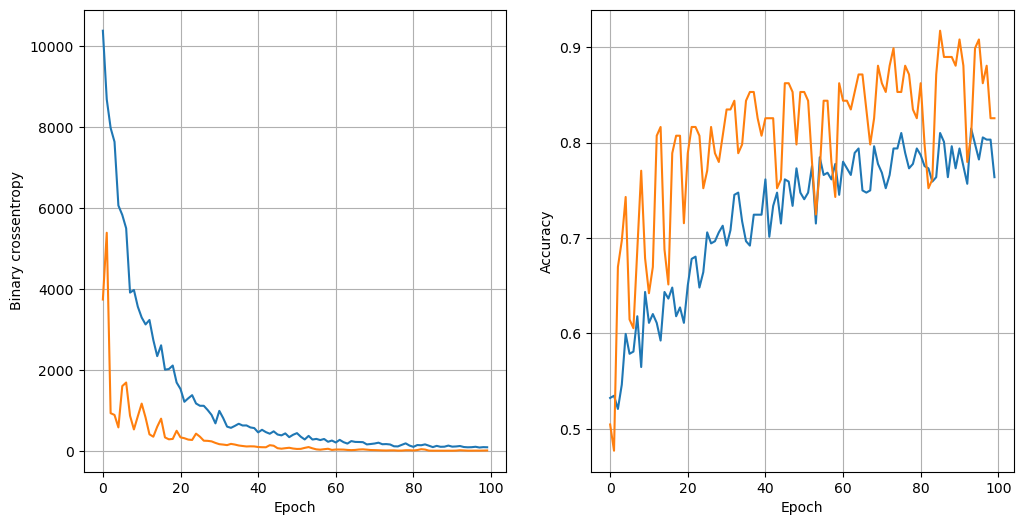

6/6 [==============================] - 0s 513us/step - loss: 5.2455 - accuracy: 0.8895


In [67]:
EPOCHS = 100
least_val_loss = float('inf')
least_loss_model = None
report = []

for num_nodes in [16, 32, 64]:
    for dropout_prob in [0, 0.2]:
        for lr in [0.01, 0.005, 0.001]:
            for batch_size in [32, 64, 128]:
                result = f"{num_nodes} nodes, dropout {dropout_prob}, learning rate {lr}, batch size {batch_size}"
                print(result)
                report.append(result)
                
                model, history = train_model(X_train, y_train, num_nodes, dropout_prob, lr, batch_size, EPOCHS, DIMENSIONS, optimizer='adam')
                plot_history(history)
                
                val_loss = model.evaluate(X_test, y_test)[0] 
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

In [68]:
y_pred = least_loss_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

6/6 [==============================] - 0s 463us/step


In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       104
           1       0.72      0.62      0.67        77

    accuracy                           0.73       181
   macro avg       0.73      0.72      0.72       181
weighted avg       0.73      0.73      0.73       181



The additional layers did not lead to an improvement or worsened performance

### Grid Search Hyperparameters

In [70]:
# Model_1
param_grid1 = {
    'n_estimators': [3,10,30],
    'max_features': [2,4,6,8]    
}

In [71]:
# Model_2
param_grid2 = {
    'n_estimators': [3,10,30],
    'max_features': [2,4,6,8],
    'min_samples_split': [2, 4],
    'max_depth': [None, 1 ,3, 9]
}

In [72]:
# Model_3
param_grid3 = {
    'n_estimators': [30,50,10],
    'max_features': [8,12,20],
    'min_samples_split': [2,4,6,8]
}

In [73]:
# Model_4
param_grid4 = {
    'n_estimators': [1,2,3,4,5],
    'max_features': [2,4,6,8],
    'max_depth': [None, 4, 8]
}

In [74]:
rf = RandomForestClassifier(min_samples_split=10, random_state=1)

In [75]:
grid_search1 = GridSearchCV(rf, param_grid1, cv=3, scoring='accuracy', return_train_score=True)
grid_search1.fit(X_train, y_train)

grid_search2 = GridSearchCV(rf, param_grid2, cv=3, scoring='accuracy', return_train_score=True)
grid_search2.fit(X_train, y_train)

grid_search3 = GridSearchCV(rf, param_grid3, cv=3, scoring='accuracy', return_train_score=True)
grid_search3.fit(X_train, y_train)

grid_search4 = GridSearchCV(rf, param_grid4, cv=3, scoring='accuracy', return_train_score=True)
grid_search4.fit(X_train, y_train)

print(grid_search1.best_estimator_)
print(grid_search2.best_estimator_)
print(grid_search3.best_estimator_)
print(grid_search4.best_estimator_)

RandomForestClassifier(max_features=8, min_samples_split=10, n_estimators=30,
                       random_state=1)
RandomForestClassifier(max_features=6, n_estimators=30, random_state=1)
RandomForestClassifier(max_features=8, min_samples_split=6, n_estimators=10,
                       random_state=1)
RandomForestClassifier(max_features=8, min_samples_split=10, n_estimators=5,
                       random_state=1)


In [76]:
best_forest1 = grid_search1.best_estimator_
best_forest1.score(X_test, y_test)

0.9502762430939227

In [77]:
best_forest2 = grid_search2.best_estimator_
best_forest2.score(X_test, y_test)

0.9447513812154696

In [78]:
best_forest3 = grid_search3.best_estimator_
best_forest3.score(X_test, y_test)

0.9392265193370166

In [79]:
best_forest4 = grid_search4.best_estimator_
best_forest4.score(X_test, y_test)

0.9447513812154696

It looks like model_1 has the highest score with the following hyperparameters; max_features=8, min_samples_split=10, n_estimators=30.

# Future Plan
1. Add more data
    a. S&P 500
    b. Unemployment rate
    c. Market sentiment
        i. Twitter
        ii. Reddit
2. Use the following models:
    a. ARMA
    b. RF
    c. NN
    d. [LSTM](https://www.youtube.com/watch?v=lhrCz6t7rmQ&list=LL&index=18&t=88s) and [explanation](https://www.youtube.com/watch?v=YCzL96nL7j0)
    
[TensorFlow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.67032&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

* Types of Neural Networks [image](https://miro.medium.com/v2/resize:fit:2000/format:webp/1*cuTSPlTq0a_327iTPJyD-Q.png)

In [80]:
df.to_csv('data/version_1.csv')